In [1]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import json # to read credentials

# SQL stuff
#import psycopg2 as ps
#import pandas.io.sql as sqlio
#from sqlalchemy import create_engine
#from sqlalchemy.types import Integer, Text, String, DateTime
#engine = create_engine('sqlite://', echo=False)
#from pyspark.sql.functions import size,col

# TRINO stuff
import trino

# Regex stuff
import re

# PDF stuff
import PyPDF2 as pypdf

# Dates stuff
from datetime import datetime, date, timedelta

# GSheet Stuff
from gspread_pandas import Spread

# Computer Stuff
import os

# Dates stuff
from datetime import datetime, date, timedelta

import pathlib
from mizani.breaks import date_breaks

# Operating system stuff
#import pathlib 

# Plot stuff
import plotnine as pn

# Statistics stuff + DS stuff
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

# Statistics Stuff
from statsmodels.stats.proportion import proportion_confint, test_proportions_2indep, proportion_effectsize

pd.set_option('display.max_columns', None)

In [2]:
## Starbust credentials (this works alone, no need to modify)
HOST = 'starburst.g8s-data-platform-prod.glovoint.com'
PORT = 443


conn_details = {
    'host': HOST,
    'port': PORT,
    'http_scheme': 'https',
    'auth': trino.auth.OAuth2Authentication()
}

In [3]:
start_date='2024-08-20' # date of the deployment + 1 day, deployed on the 19th
end_date='2024-08-26' # date of the run

In [4]:
#new query
query= f'''
SELECT DATE(DATE_TRUNC('day', rfs.p_creation_date)) AS date
        , CASE 
            WHEN CAST(json_extract_scalar(rfs.features, '$.customer.finishedOrdersCount') AS INT) = 0 THEN 'NC' 
            ELSE 'EC'
        END AS customer_type
        , rfs.risk_feature_snapshot_creation_datetime AS rfs_creation_date
        , rfs.risk_feature_snapshot_id AS id
        , rfs.customer_id
        , json_extract_scalar(rfs.features, '$.order.countryCode') AS order_country
        , json_extract_scalar(rfs.features, '$.customer.ordersCount') AS ordersCount
        , json_extract_scalar(rfs.features, '$.customer.debtOrdersCount') AS debtOrdersCount 
        
        , JSON_EXTRACT_SCALAR(rfs.features, '$.order.amountInEur.amountMajor')   AS order_amount_eur
        , JSON_EXTRACT_SCALAR(rfs.features, '$.customer.debtTotalInEur')         AS debt_amount_eur
        
        , NULLIF(json_extract_scalar(rfs.features, '$.ml.ml_uch.score'), ' ') AS production_score
        , NULLIF(json_extract_scalar(rfs.features, '$.ml.ml_uch.shadowing.ml_uch_v0.score'),' ') AS shadowing_score
        

        -- CHECKOUT 
        , co.checkout_status
        
        -- ORDERS 
        , o.order_created_at AS order_creation_date 
        , o.order_country_code
        , o.order_id
        , row_number() over (PARTITION BY o.order_id  order by o.order_created_at asc) as first_order_id -- security_check
        , o.order_cancel_reason
        , o.order_total_purchase_eur AS gmv_euros
        
        -- PAYMENTS
        , p.payment_status
        , p.payment_method
        --, p.payment_forgiven
        --, round(round(abs(p.balance) / 100.00, 2)*o.order_exchange_rate_to_eur, 2) AS p_balance_eur
        --, round(round(p.amount_paid / 100.00, 2)*o.order_exchange_rate_to_eur, 2) AS p_amount_paid_eur
        -- cm
        , cm.gmvalu_eur AS GMV_cm_table
        , cm.contribution_margin_eur 
FROM (SELECT * FROM sensitive_delta.central_risk_engine_odp.risk_feature_snapshots_enhanced WHERE TRUE 
            AND checkpoint = 'checkout' 
            AND crc32(cast ('global-cg' || cast(customer_id as varchar) as varbinary)) < (0.04 * 4294967295) 
            AND DATE(p_creation_date)>=DATE('{start_date}') AND DATE(p_creation_date)<DATE('{end_date}') 
            AND json_extract_scalar(features, '$.payment_method.type')='CASH'
            --AND NULLIF(json_extract_scalar(features, '$.ml.ml_uch.shadowing.ml_uch_v0.score'),' ') IS NOT NULL
            --AND NULLIF(json_extract_scalar(features, '$.ml.ml_uch.score'), ' ') IS NOT NULL
    ) rfs
    LEFT JOIN sensitive_delta.sensitive_fintech__checkout_orders__odp.checkout_orders co ON co.checkout_id=rfs.checkout_id AND DATE(co.p_creation_date)>=DATE('{start_date}') AND DATE(co.p_creation_date)<DATE('{end_date}')
    LEFT JOIN delta.central_order_descriptors_odp.order_descriptors_v2                 o ON o.order_id = co.order_id AND DATE(o.p_creation_date)>=DATE('{start_date}') AND DATE(o.p_creation_date)<DATE('{end_date}')
    LEFT JOIN delta.fintech_payments_odp.payments                                      p ON p.order_id = o.order_id AND DATE(p.p_creation_date)>=DATE('{start_date}') AND DATE(p.p_creation_date)<DATE('{end_date}')
    LEFT JOIN delta.finance_financial_reports_odp.pnl_order_level                     cm ON cm.order_id=o.order_id AND DATE(cm.p_creation_date)>=DATE('{start_date}') AND DATE(cm.p_creation_date)<DATE('{end_date}')  


'''


In [5]:
# To export result to pandas
with trino.dbapi.connect(**conn_details) as conn:
    df = pd.read_sql_query(query, conn)

/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_89033/1346933151.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


# Function definitions

In [6]:
def calculate_percentiles(df, target_column='target'):
    # Initialize an empty list to store the percentile data
    percentiles_list = []
    
    # Define the percentiles you want to calculate
    percentile_ranks = [0, 1, 5, 10, 20, 30, 40, 50, 60, 70, 75, 80, 90, 95, 96, 97, 98, 99, 100]
    percentile_names = ['0th', '1st', '5th', '10th', '20th', '30th', '40th', '50th', '60th', '70th','75th', '80th', '90th', '95th','96th', '97th','98th', '99th', '100th']
    
    # Calculate the percentiles for the target column
    target_data = df[target_column]
    percentiles = np.nanpercentile(target_data, percentile_ranks)
    
    percentiles_list = list(percentiles) if isinstance(percentiles, np.ndarray) else [percentiles]
    
    # Create a DataFrame from the list with percentiles
    df_percentiles = pd.DataFrame([percentiles_list], columns=percentile_names)
    
    return df_percentiles

In [7]:
def plot_roc_curve(df, preds_col=None, label_col=None):

    # Create a copy of the predicted probabilities column and normalize it
    preds_normalized = df[preds_col] / 100.0

    # Create the ROC curve
    fpr, tpr, thresholds = roc_curve(df[label_col], preds_normalized)

    # Calculate the AUC
    auc = roc_auc_score(df[label_col], preds_normalized)

    # Convert the thresholds to a scale of 0 to 100 and round them
    thresholds_rounded = (thresholds * 100).round()

    # Plot the ROC curve
    df_fpr_tpr = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds_rounded})

    # Create the data viz
    print(f"Thresholds: {thresholds_rounded}")
    print(f"AUC: {auc}")
    return (
        pn.ggplot(data=df_fpr_tpr) +
        pn.geom_point(
            pn.aes(
                x='FPR',
                y='TPR',
                size='Threshold',
                color='Threshold'
            )
        ) +
        pn.geom_line(
            pn.aes(
                x='FPR',
                y='TPR'
            )
        ) +
        pn.geom_abline(
            slope=1, intercept=0, linetype='dashed', color='red'
        ) +
        pn.labs(title=f'ROC Curve (AUC = {auc:.2f})') +
        pn.xlab('False Positive Rate') +
        pn.ylab('True Positive Rate') +
        pn.theme_minimal()
    )

In [8]:
def plot_precision_recall(df, preds_col=None, label_col=None):

    if preds_col == None:
        preds_col = "captcha_score"
        
    if label_col == None:
        label_col = "captcha_score"

    # Create the Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(df[label_col], df[preds_col])

    # Plot the ROC curve
    df_recall_precision = pd.DataFrame({
        'Precision':precision[:-1],
        'Recall':recall[:-1],
        'Threshold':thresholds
    })

# Creat a data viz
    return(
        pn.ggplot(data = df_recall_precision) +
        pn.geom_point(
            pn.aes(
                x = 'Recall',
                y = 'Precision',
                size='Threshold'
            )
        ) +
        pn.geom_line(
            pn.aes(
                x = 'Recall',
                y = 'Precision'
            )
        )+
        pn.labs(title = 'Recall Precision Curve')+
        pn.xlab('Recall')+
        pn.ylab('Precision')+
        pn.theme_minimal()
    )

# EDA

In [9]:
df.dtypes

date                                    object
customer_type                           object
rfs_creation_date          datetime64[ns, UTC]
id                                       int64
customer_id                              int64
order_country                           object
ordersCount                             object
debtOrdersCount                         object
order_amount_eur                        object
debt_amount_eur                         object
production_score                        object
shadowing_score                         object
checkout_status                         object
order_creation_date        datetime64[ns, UTC]
order_country_code                      object
order_id                               float64
first_order_id                           int64
order_cancel_reason                     object
gmv_euros                              float64
payment_status                          object
payment_method                          object
GMV_cm_table 

In [10]:
len(df)

57073

In [11]:
df.isna().sum()

date                           0
customer_type                  0
rfs_creation_date              0
id                             0
customer_id                    0
order_country                  0
ordersCount                    0
debtOrdersCount                0
order_amount_eur               0
debt_amount_eur                0
production_score             263
shadowing_score              279
checkout_status               10
order_creation_date          662
order_country_code           662
order_id                     662
first_order_id                 0
order_cancel_reason        55201
gmv_euros                    662
payment_status               662
payment_method               662
GMV_cm_table                 662
contribution_margin_eur      662
dtype: int64

In [14]:
df['order_id'].isna().sum()/len(df)

0.011599179997547001

### NOTE
1% of the CG does not have an order, probably this because was affected or blocked by RE rules that do not consider the exclusion of the CG 

In [15]:
df['date']=pd.to_datetime(df['date'])
df['debtOrdersCount']=df['debtOrdersCount'].astype('int64')
df['order_amount_eur']=df['order_amount_eur'].astype('float64')
df['debt_amount_eur']=df['debt_amount_eur'].astype('float64')
df['production_score'] = df['production_score'].fillna('0')
df['shadowing_score'] = df['shadowing_score'].fillna('0')
df2=df.copy()
df = df.dropna(subset=['order_id'])

In [16]:
orders = df[['date', 'payment_status']].groupby(
    ['payment_status', pd.Grouper(key='date', freq='1D')]
    ).agg(
        counts = ('date', 'count')
    ).reset_index()

In [17]:
orders['payment_status'] = orders['payment_status'].astype('category')

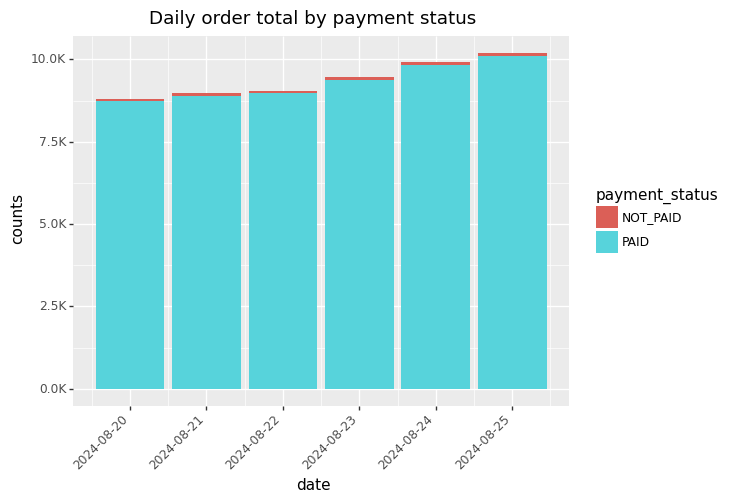

<ggplot: (398148425)>

In [18]:
# Daily Captcha calls without null score plot
(
    pn.ggplot(orders.reset_index(), pn.aes(x='date', y='counts', fill='payment_status')) +
    pn.geom_col() +
    pn.ggtitle('Daily order total by payment status') + 
    pn.scale_y_continuous(labels=lambda l: ['{:.1f}K'.format(v / 1000) for v in l]) +
    pn.theme(axis_text_x=pn.element_text(rotation=45, hjust=1)) 
    #+
    #pn.scale_fill_manual(values=['red', 'blue'])
)

# Production Score Distribution

In [29]:
df['production_score']=df['production_score'].astype('int64')

/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_89033/3672602580.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_89033/3672602580.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [30]:
production_score=df.groupby(
        ['production_score','payment_status'],
        as_index=False
    ).agg(
        counts=('production_score', 'count')
    ).reset_index()

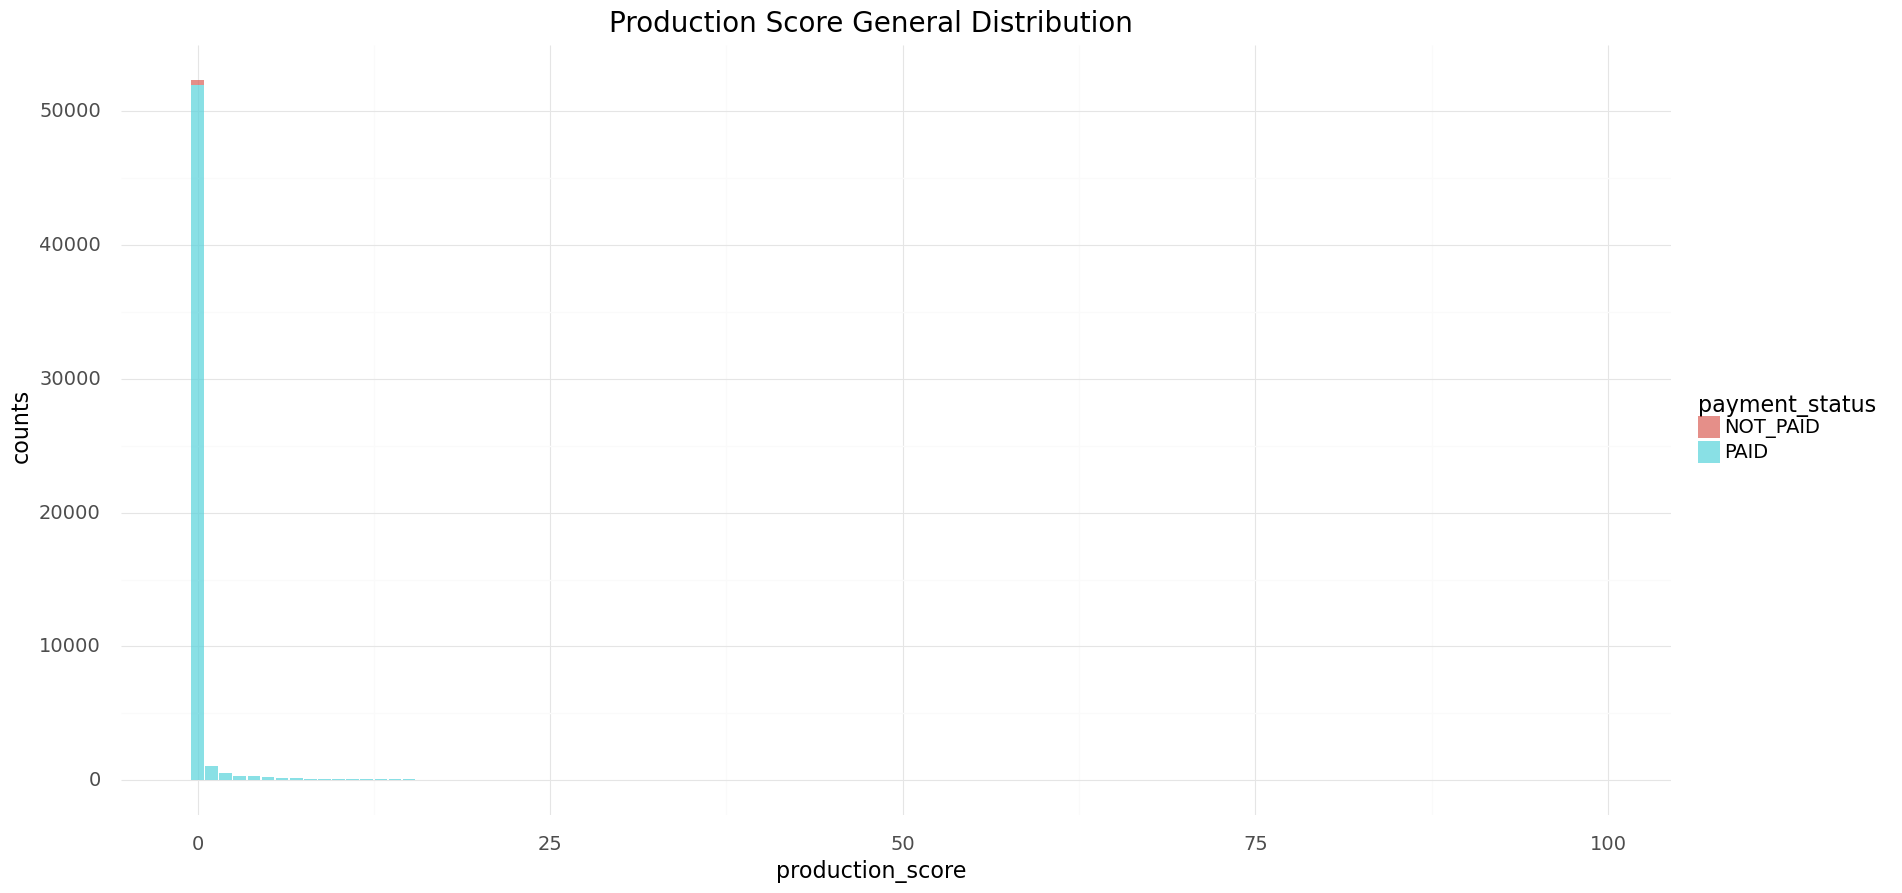

<ggplot: (399698989)>

In [31]:
(pn.ggplot(production_score) +
    pn.geom_bar(pn.aes(x='production_score', y='counts', fill="payment_status"), stat="identity", alpha=0.7) +
    #pn.scale_y_continuous(name="Orders", labels=lambda l: ['{:.1f}M'.format(v / 1000000) for v in l]) +
    #pn.scale_x_continuous(name="Production Score"#,
                         # breaks=range(int(final_df['MAX_ordersCount'].min()), int(final_df['MAX_ordersCount'].max()) + 1, 1),  # Adjust the range and step as needed
                          #labels=lambda l: ['{:.0f}'.format(v) for v in l]  # Optional formatting for x-axis labels
    #) +
    pn.theme_minimal() +
    pn.labs(title="Production Score General Distribution")+
    pn.theme(figure_size=(20, 10),  # Adjust figure size as needed
         # Adjusting title and labels size
          title=pn.element_text(size=20),  # Adjust title size
          axis_title=pn.element_text(size=16),  # Adjust axis titles size
          axis_text=pn.element_text(size=14),  # Adjust axis labels size
         # Adjusting legend title and text size
          legend_title=pn.element_text(size=16),  # Adjust legend title size
          legend_text=pn.element_text(size=14))  # Adjust legend text size
)

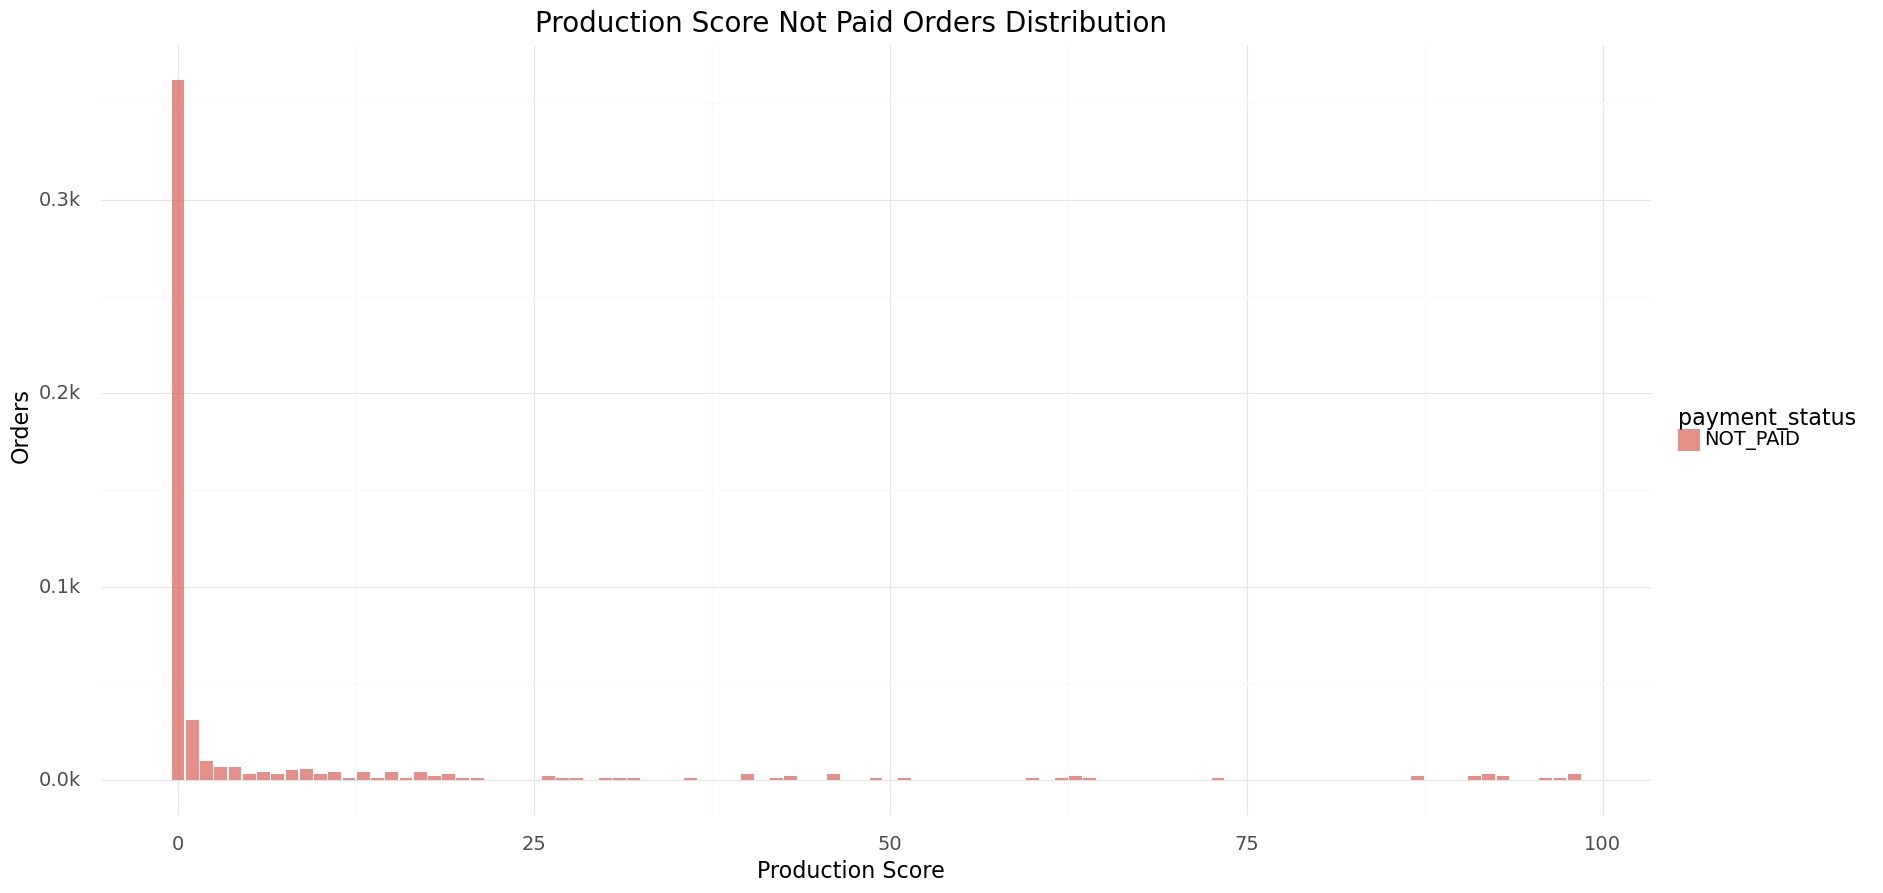

<ggplot: (675396813)>

In [37]:
(
    pn.ggplot(production_score.query('payment_status=="NOT_PAID"').reset_index(drop=True)) +
    pn.geom_bar(pn.aes(x='production_score', y='counts', fill="payment_status"), stat="identity", alpha=0.7) +
    pn.scale_y_continuous(name="Orders", labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]) +
    pn.scale_x_continuous(name="Production Score"#,
                         # breaks=range(int(final_df['MAX_ordersCount'].min()), int(final_df['MAX_ordersCount'].max()) + 1, 1),  # Adjust the range and step as needed
                          #labels=lambda l: ['{:.0f}'.format(v) for v in l]  # Optional formatting for x-axis labels
    ) +
    pn.theme_minimal() +
    pn.labs(title="Production Score Not Paid Orders Distribution")+
    pn.theme(figure_size=(20, 10),  # Adjust figure size as needed
         # Adjusting title and labels size
          title=pn.element_text(size=20),  # Adjust title size
          axis_title=pn.element_text(size=16),  # Adjust axis titles size
          axis_text=pn.element_text(size=14),  # Adjust axis labels size
         # Adjusting legend title and text size
          legend_title=pn.element_text(size=16),  # Adjust legend title size
          legend_text=pn.element_text(size=14))  # Adjust legend text size
)

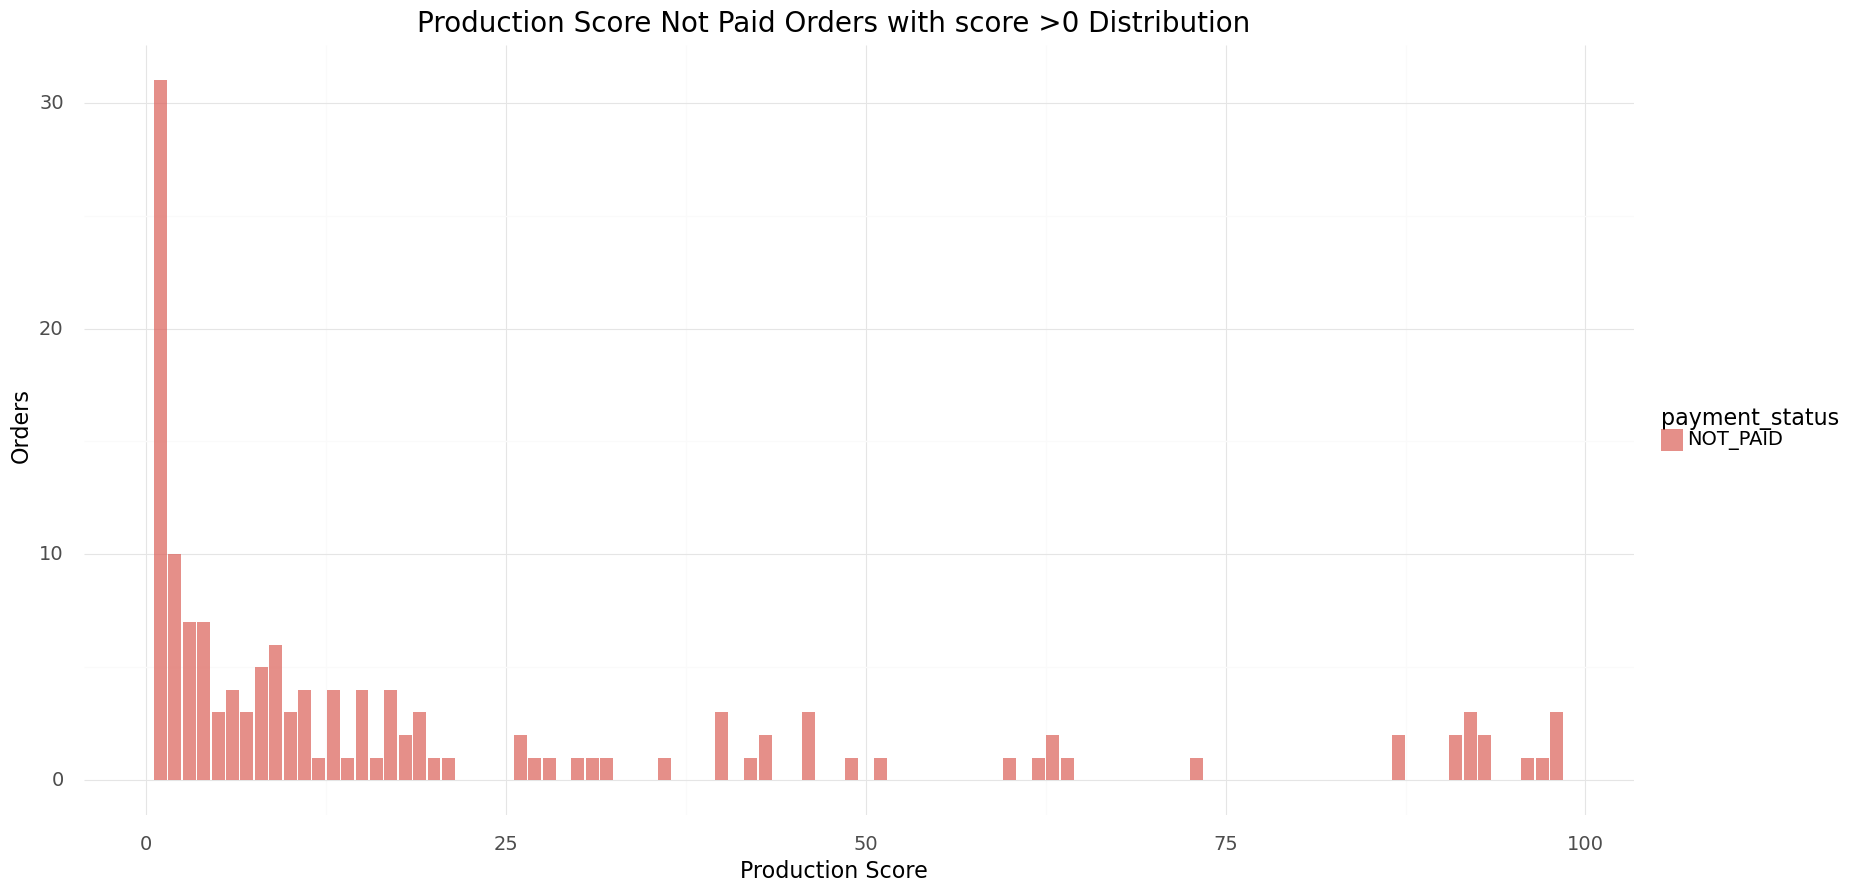

<ggplot: (676320241)>

In [38]:
(
    pn.ggplot(production_score.query('payment_status=="NOT_PAID" & production_score>0').reset_index(drop=True)) +
    pn.geom_bar(pn.aes(x='production_score', y='counts', fill="payment_status"), stat="identity", alpha=0.7) +
    pn.scale_y_continuous(name="Orders"#, labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]
                         ) +
    pn.scale_x_continuous(name="Production Score"#,
                         # breaks=range(int(final_df['MAX_ordersCount'].min()), int(final_df['MAX_ordersCount'].max()) + 1, 1),  # Adjust the range and step as needed
                          #labels=lambda l: ['{:.0f}'.format(v) for v in l]  # Optional formatting for x-axis labels
    ) +
    pn.theme_minimal() +
    pn.labs(title="Production Score Not Paid Orders with score >0 Distribution")+
    pn.theme(figure_size=(20, 10),  # Adjust figure size as needed
         # Adjusting title and labels size
          title=pn.element_text(size=20),  # Adjust title size
          axis_title=pn.element_text(size=16),  # Adjust axis titles size
          axis_text=pn.element_text(size=14),  # Adjust axis labels size
         # Adjusting legend title and text size
          legend_title=pn.element_text(size=16),  # Adjust legend title size
          legend_text=pn.element_text(size=14))  # Adjust legend text size
)

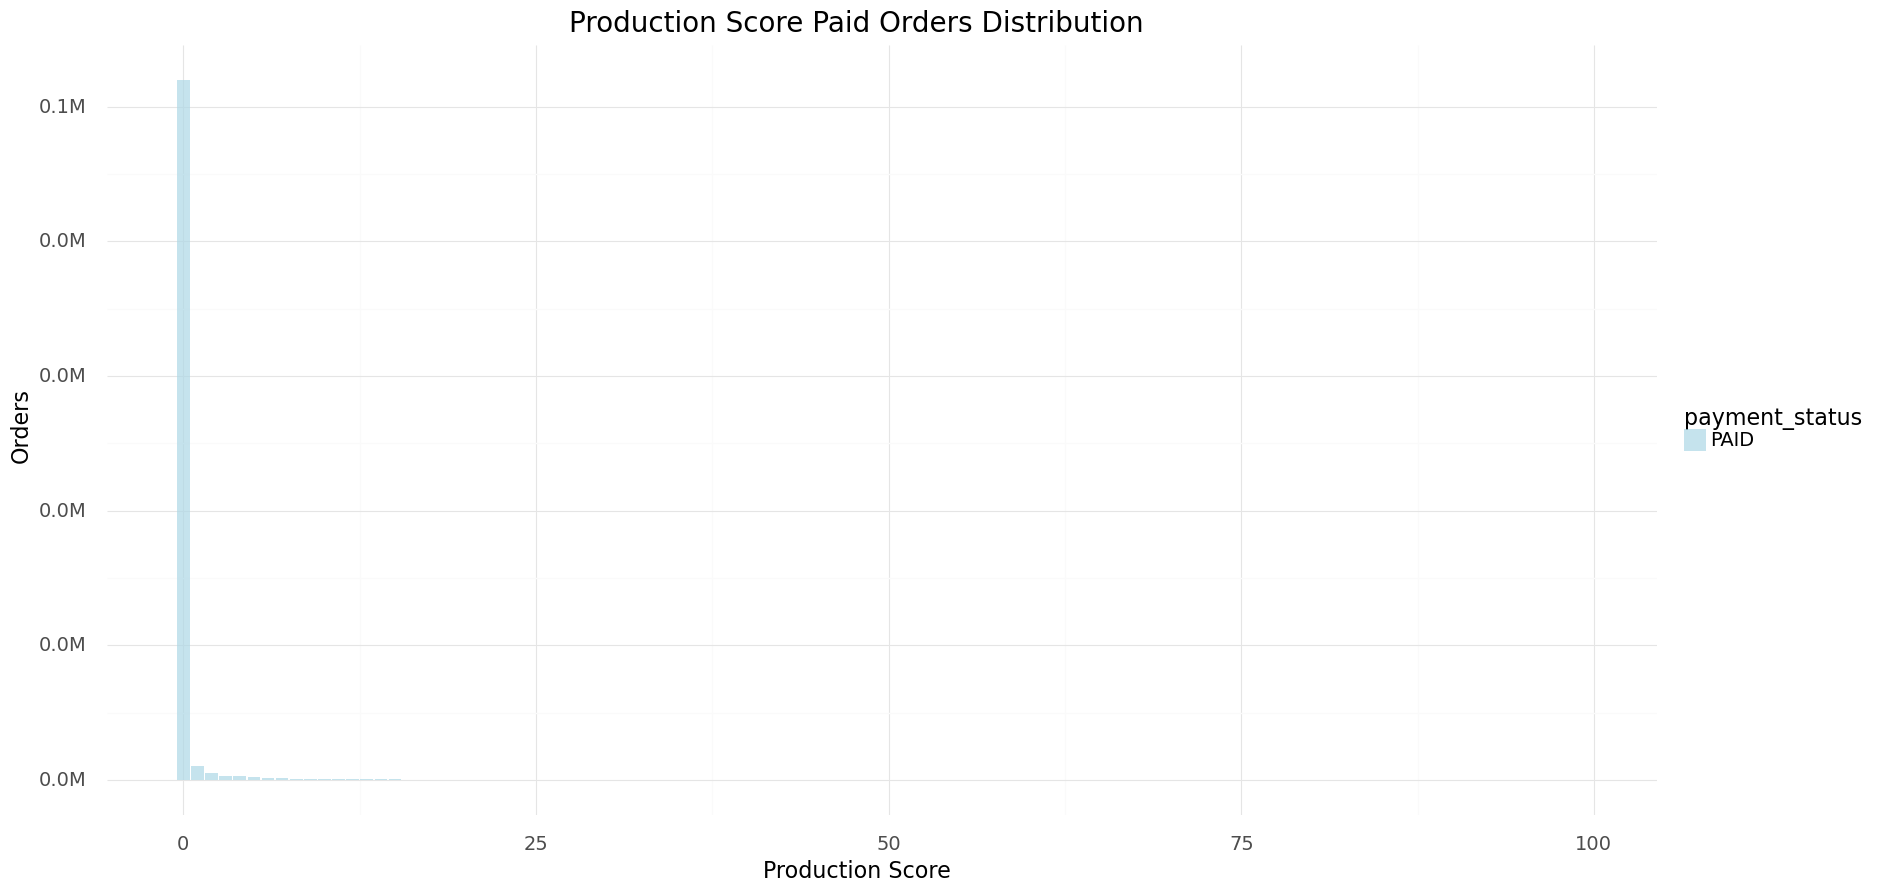

<ggplot: (675321513)>

In [39]:
(
    pn.ggplot(production_score.query('payment_status=="PAID"').reset_index(drop=True)) +
    pn.geom_bar(pn.aes(x='production_score', y='counts', fill="payment_status"), stat="identity", alpha=0.7) +
    pn.scale_y_continuous(name="Orders", labels=lambda l: ['{:.1f}M'.format(v / 1000000) for v in l]) +
    pn.scale_fill_manual(values={"PAID": "lightblue"}) + 
    pn.scale_x_continuous(name="Production Score"#,
                         # breaks=range(int(final_df['MAX_ordersCount'].min()), int(final_df['MAX_ordersCount'].max()) + 1, 1),  # Adjust the range and step as needed
                          #labels=lambda l: ['{:.0f}'.format(v) for v in l]  # Optional formatting for x-axis labels
    ) +
    pn.theme_minimal() +
    pn.labs(title="Production Score Paid Orders Distribution")+
    pn.theme(figure_size=(20, 10),  # Adjust figure size as needed
         # Adjusting title and labels size
          title=pn.element_text(size=20),  # Adjust title size
          axis_title=pn.element_text(size=16),  # Adjust axis titles size
          axis_text=pn.element_text(size=14),  # Adjust axis labels size
         # Adjusting legend title and text size
          legend_title=pn.element_text(size=16),  # Adjust legend title size
          legend_text=pn.element_text(size=14))  # Adjust legend text size
)

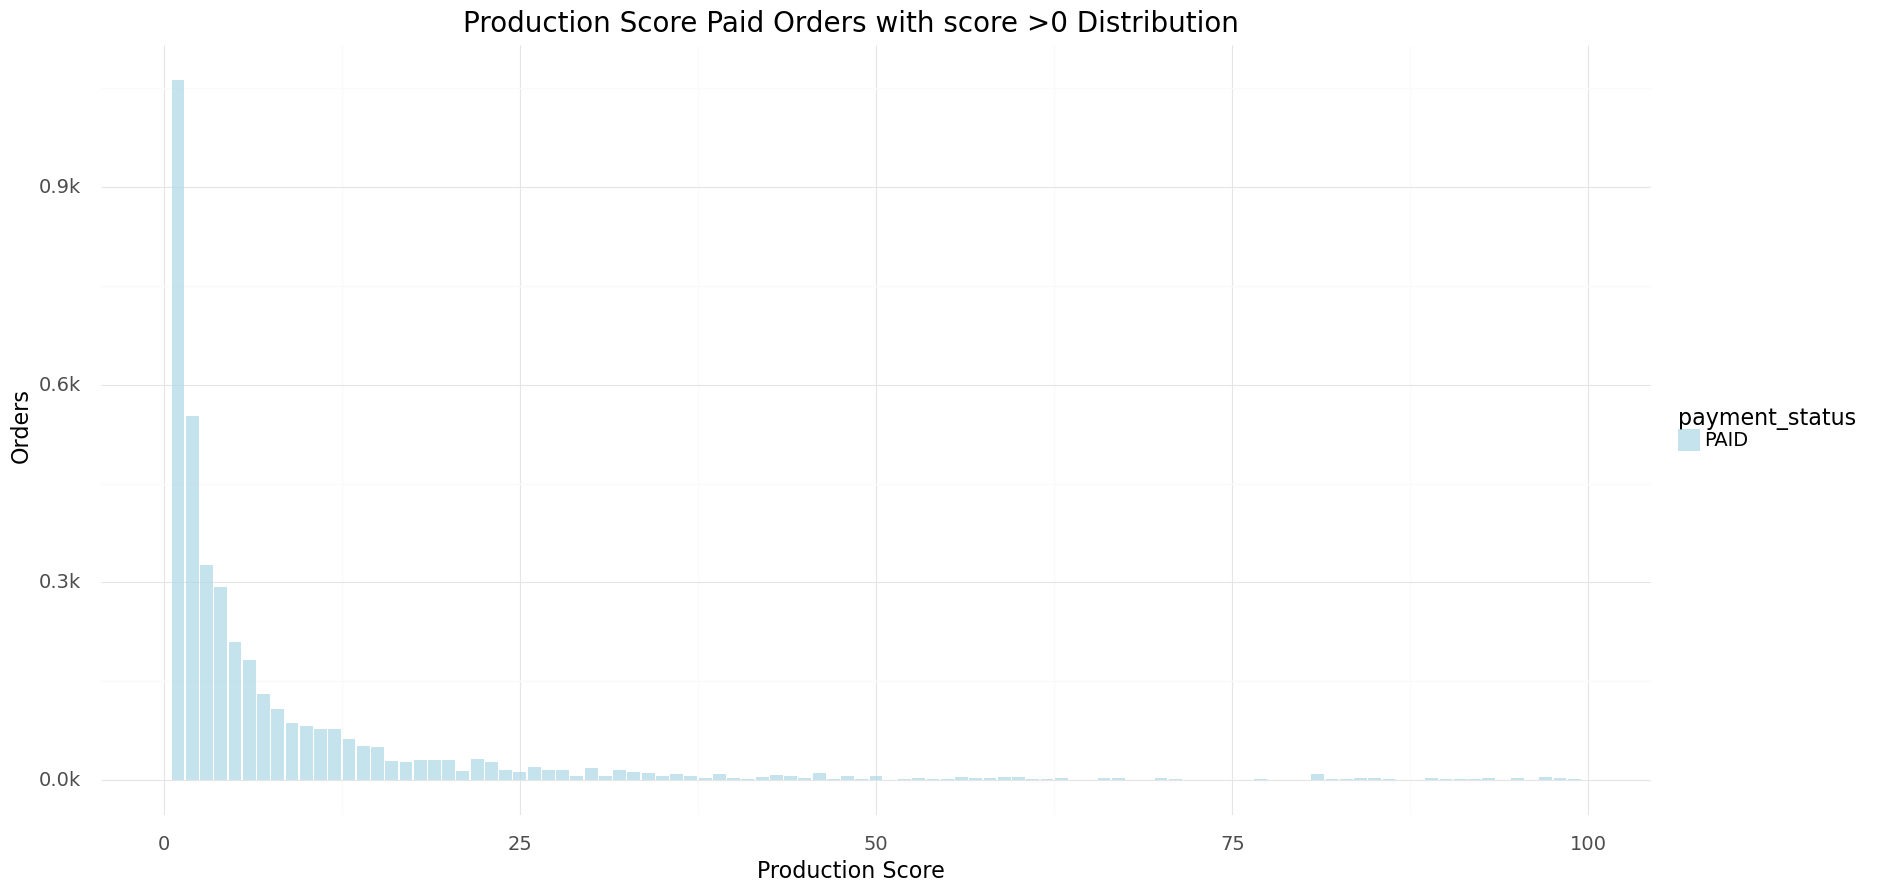

<ggplot: (674363373)>

In [40]:
(
    pn.ggplot(production_score.query('payment_status=="PAID" & production_score>0').reset_index(drop=True)) +
    pn.geom_bar(pn.aes(x='production_score', y='counts', fill="payment_status"), stat="identity", alpha=0.7) +
    pn.scale_fill_manual(values={"PAID": "lightblue"}) + 
    pn.scale_y_continuous(name="Orders", labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]
                         ) +
    pn.scale_x_continuous(name="Production Score"#,
                         # breaks=range(int(final_df['MAX_ordersCount'].min()), int(final_df['MAX_ordersCount'].max()) + 1, 1),  # Adjust the range and step as needed
                          #labels=lambda l: ['{:.0f}'.format(v) for v in l]  # Optional formatting for x-axis labels
    ) +
    pn.theme_minimal() +
    pn.labs(title="Production Score Paid Orders with score >0 Distribution")+
    pn.theme(figure_size=(20, 10),  # Adjust figure size as needed
         # Adjusting title and labels size
          title=pn.element_text(size=20),  # Adjust title size
          axis_title=pn.element_text(size=16),  # Adjust axis titles size
          axis_text=pn.element_text(size=14),  # Adjust axis labels size
         # Adjusting legend title and text size
          legend_title=pn.element_text(size=16),  # Adjust legend title size
          legend_text=pn.element_text(size=14))  # Adjust legend text size
)

# Shadowing Score Distribution

In [32]:
df['shadowing_score']=df['shadowing_score'].astype('int64')

/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_89033/4288628492.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [33]:
shadowing_score=df.groupby(
        ['shadowing_score','payment_status'],
        as_index=False
    ).agg(
        counts=('shadowing_score', 'count')
    ).reset_index()

shadowing_score['shadowing_score'] = pd.to_numeric(shadowing_score['shadowing_score'], errors='coerce')

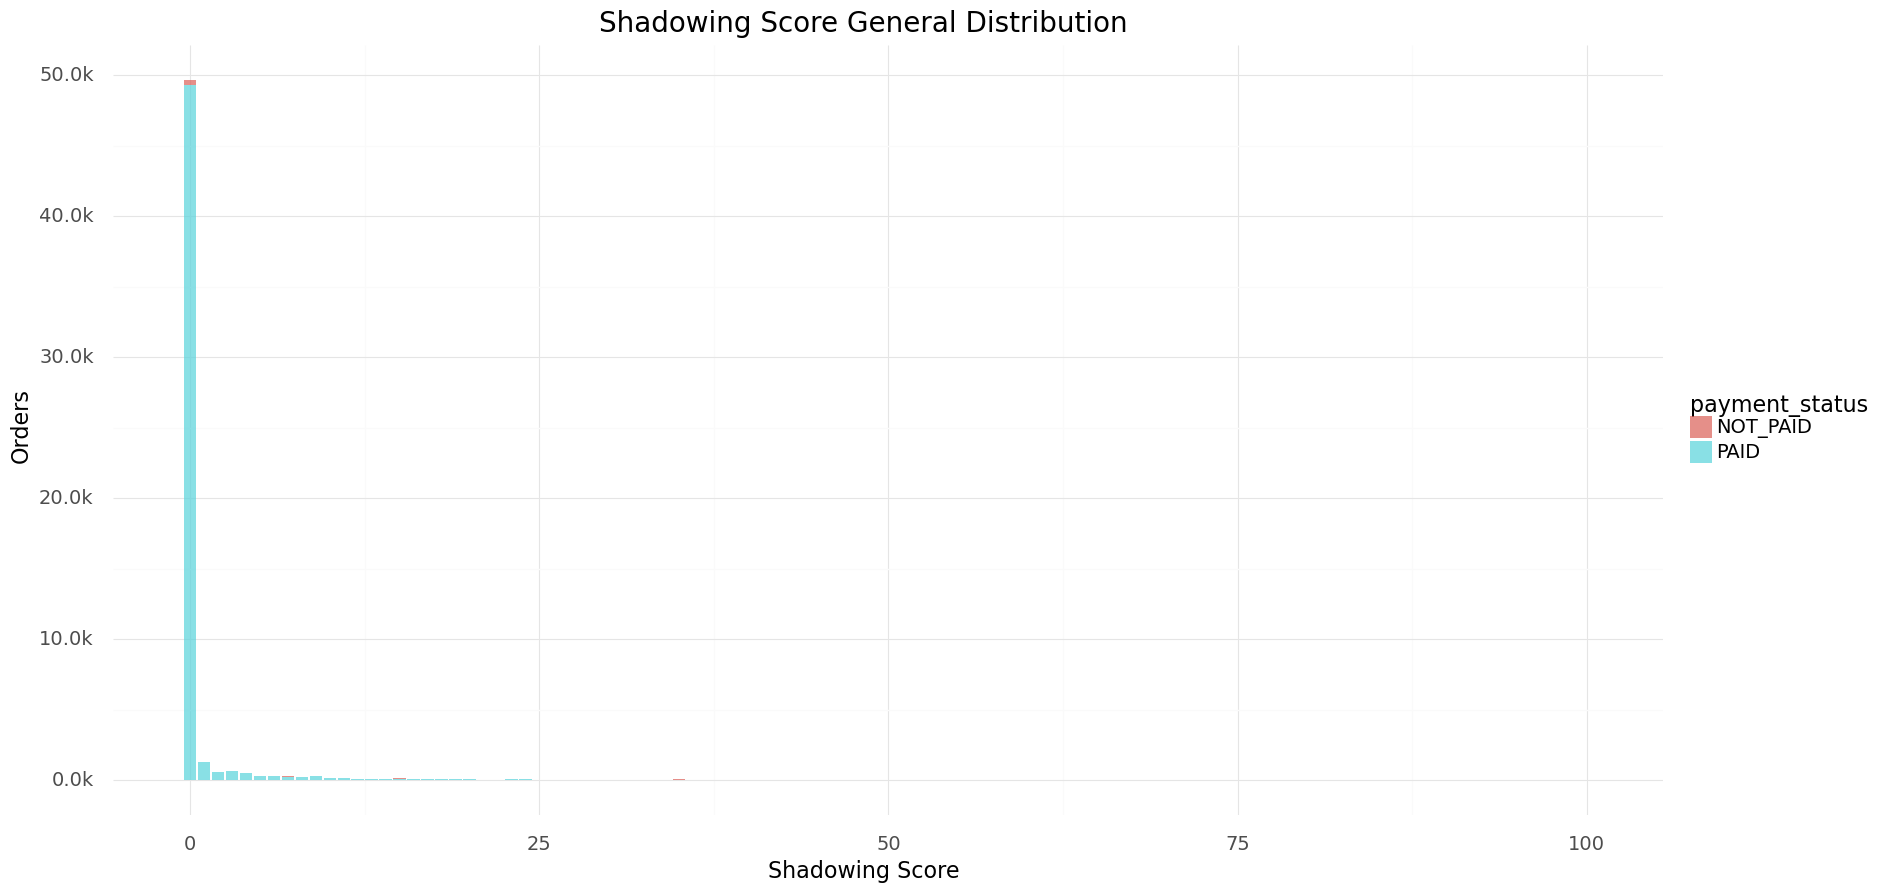

<ggplot: (674539073)>

In [36]:
(
    pn.ggplot(shadowing_score) +
    pn.geom_bar(pn.aes(x='shadowing_score', y='counts', fill="payment_status"), stat="identity", alpha=0.7) +
    pn.scale_y_continuous(name="Orders", labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]) +
    pn.scale_x_continuous(name="Shadowing Score"#,
                         # breaks=range(int(final_df['MAX_ordersCount'].min()), int(final_df['MAX_ordersCount'].max()) + 1, 1),  # Adjust the range and step as needed
                          #labels=lambda l: ['{:.0f}'.format(v) for v in l]  # Optional formatting for x-axis labels
    ) +
    pn.theme_minimal() +
    pn.labs(title="Shadowing Score General Distribution")+
    pn.theme(figure_size=(20, 10),  # Adjust figure size as needed
         # Adjusting title and labels size
          title=pn.element_text(size=20),  # Adjust title size
          axis_title=pn.element_text(size=16),  # Adjust axis titles size
          axis_text=pn.element_text(size=14),  # Adjust axis labels size
         # Adjusting legend title and text size
          legend_title=pn.element_text(size=16),  # Adjust legend title size
          legend_text=pn.element_text(size=14))  # Adjust legend text size
)


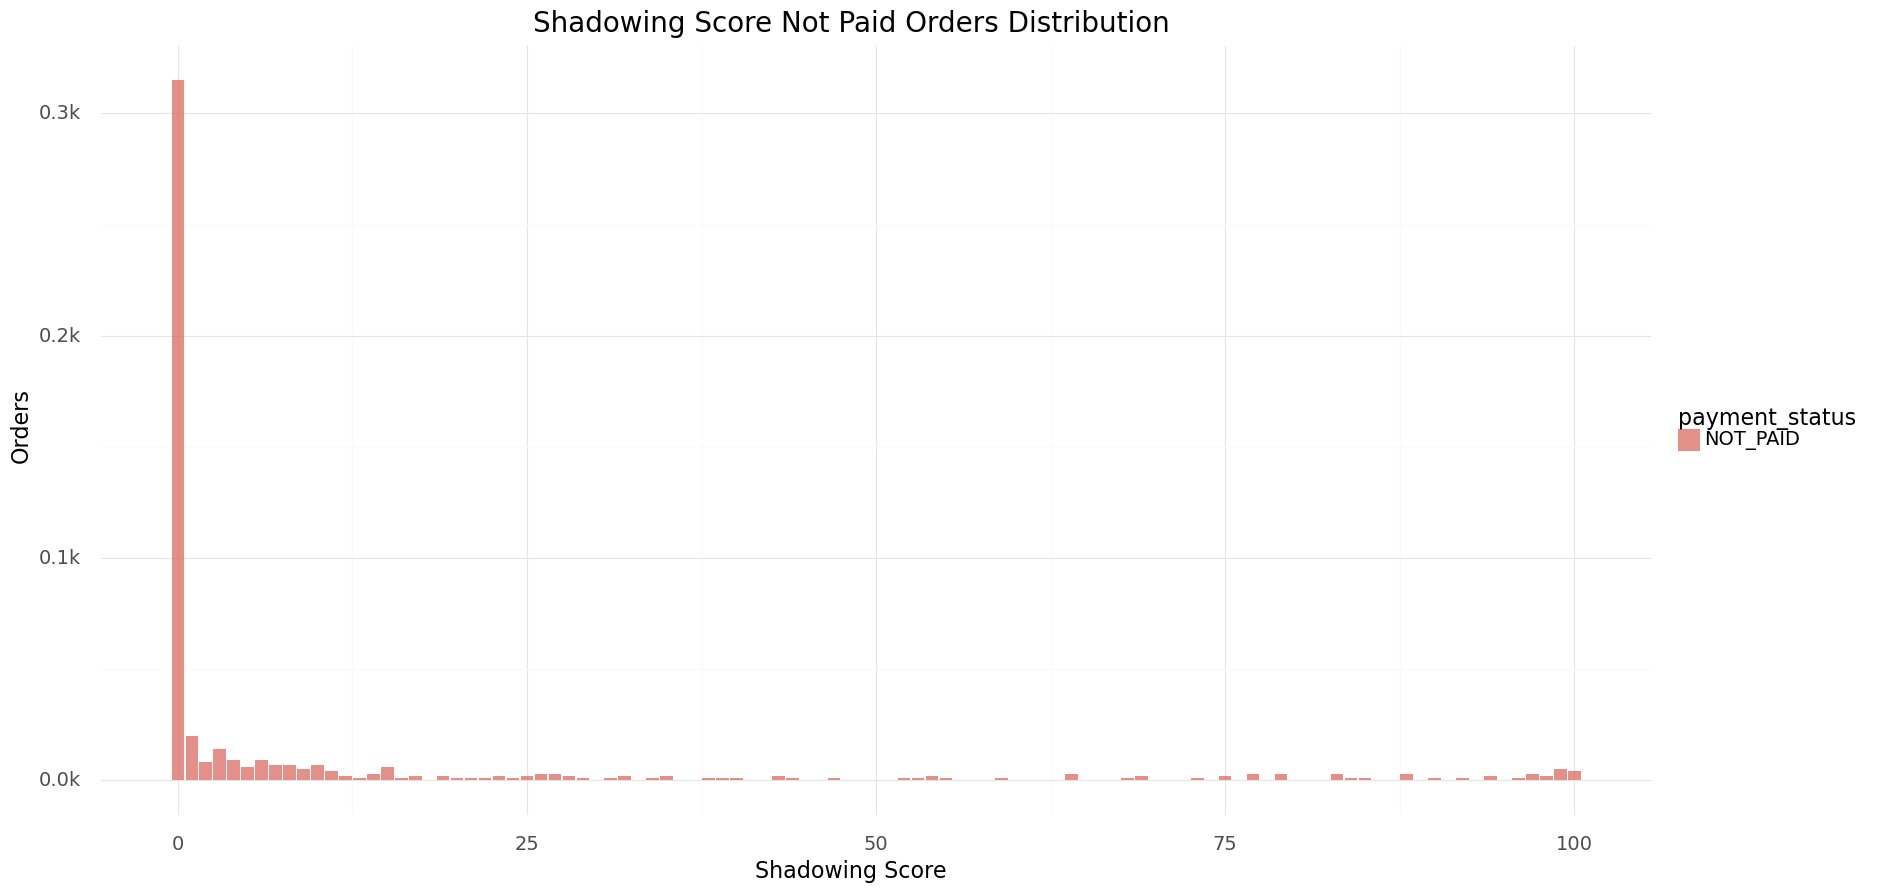

<ggplot: (674301593)>

In [41]:
(
    pn.ggplot(shadowing_score.query('payment_status=="NOT_PAID"').reset_index(drop=True)) +
    pn.geom_bar(pn.aes(x='shadowing_score', y='counts', fill="payment_status"), stat="identity", alpha=0.7) +
    pn.scale_y_continuous(name="Orders", labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]) +
    pn.scale_x_continuous(name="Shadowing Score"#,
                         # breaks=range(int(final_df['MAX_ordersCount'].min()), int(final_df['MAX_ordersCount'].max()) + 1, 1),  # Adjust the range and step as needed
                          #labels=lambda l: ['{:.0f}'.format(v) for v in l]  # Optional formatting for x-axis labels
    ) +
    pn.theme_minimal() +
    pn.labs(title="Shadowing Score Not Paid Orders Distribution")+
    pn.theme(figure_size=(20, 10),  # Adjust figure size as needed
         # Adjusting title and labels size
          title=pn.element_text(size=20),  # Adjust title size
          axis_title=pn.element_text(size=16),  # Adjust axis titles size
          axis_text=pn.element_text(size=14),  # Adjust axis labels size
         # Adjusting legend title and text size
          legend_title=pn.element_text(size=16),  # Adjust legend title size
          legend_text=pn.element_text(size=14))  # Adjust legend text size
)

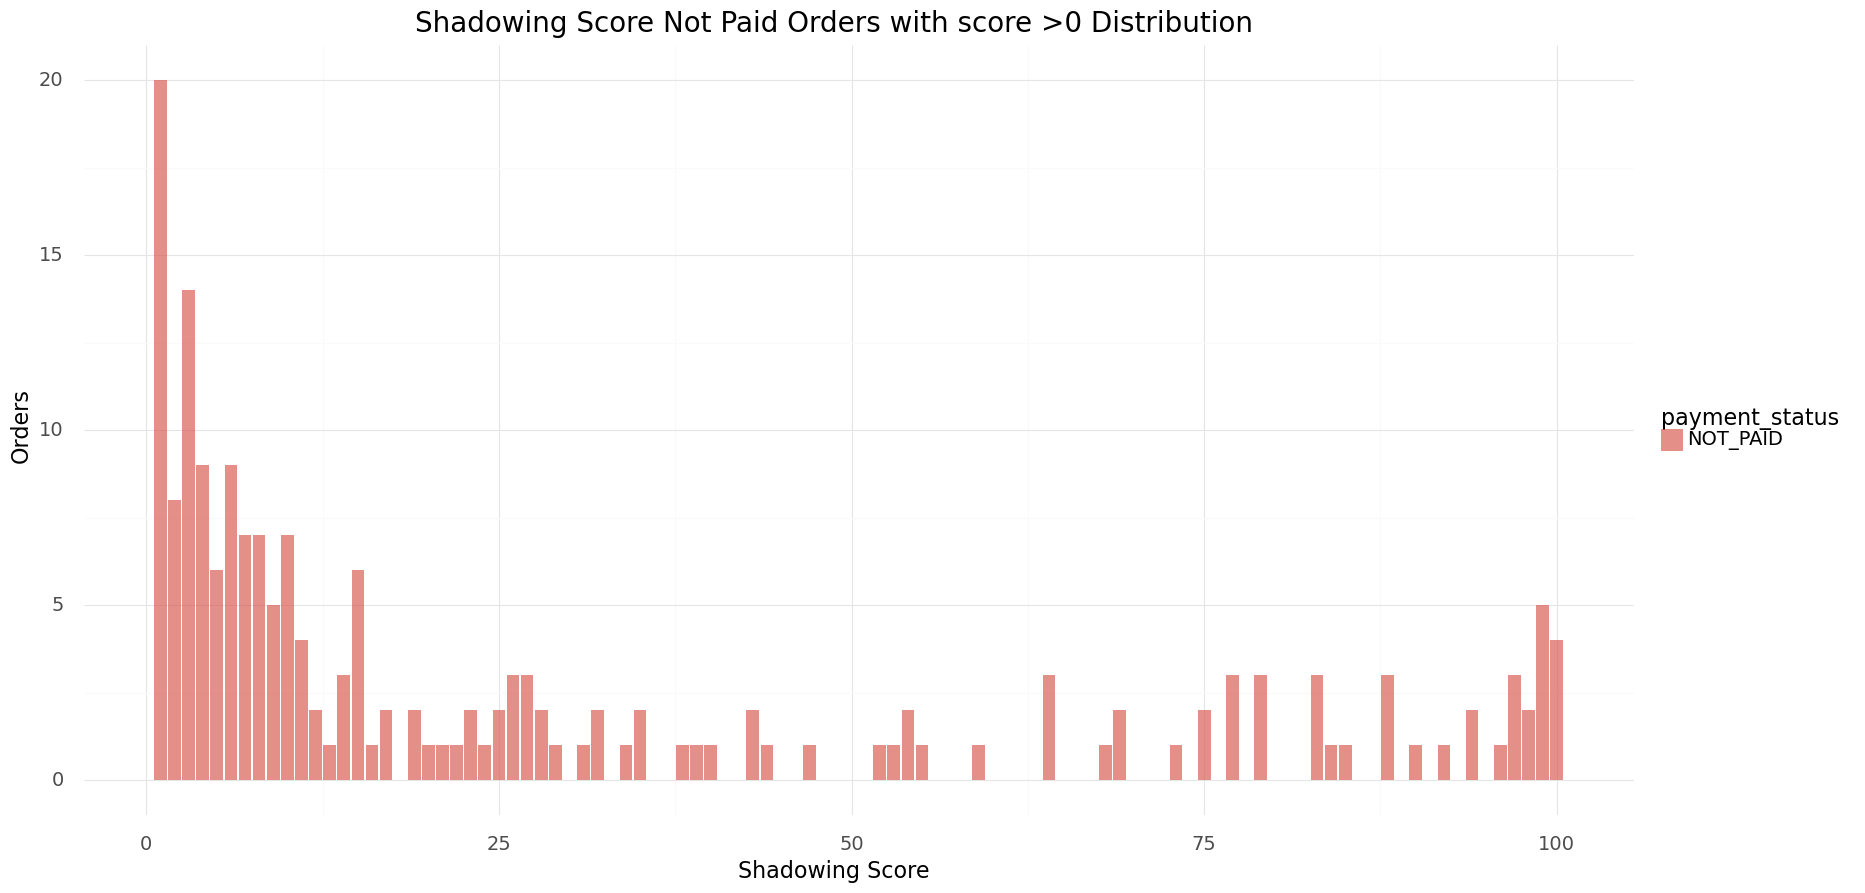

<ggplot: (674213401)>

In [42]:
(
    pn.ggplot(shadowing_score.query('payment_status=="NOT_PAID" & shadowing_score>0').reset_index(drop=True)) +
    pn.geom_bar(pn.aes(x='shadowing_score', y='counts', fill="payment_status"), stat="identity", alpha=0.7) +
    pn.scale_y_continuous(name="Orders"#, labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]
                         ) +
    pn.scale_x_continuous(name="Shadowing Score"#,
                         # breaks=range(int(final_df['MAX_ordersCount'].min()), int(final_df['MAX_ordersCount'].max()) + 1, 1),  # Adjust the range and step as needed
                          #labels=lambda l: ['{:.0f}'.format(v) for v in l]  # Optional formatting for x-axis labels
    ) +
    pn.theme_minimal() +
    pn.labs(title="Shadowing Score Not Paid Orders with score >0 Distribution")+
    pn.theme(figure_size=(20, 10),  # Adjust figure size as needed
         # Adjusting title and labels size
          title=pn.element_text(size=20),  # Adjust title size
          axis_title=pn.element_text(size=16),  # Adjust axis titles size
          axis_text=pn.element_text(size=14),  # Adjust axis labels size
         # Adjusting legend title and text size
          legend_title=pn.element_text(size=16),  # Adjust legend title size
          legend_text=pn.element_text(size=14))  # Adjust legend text size
)

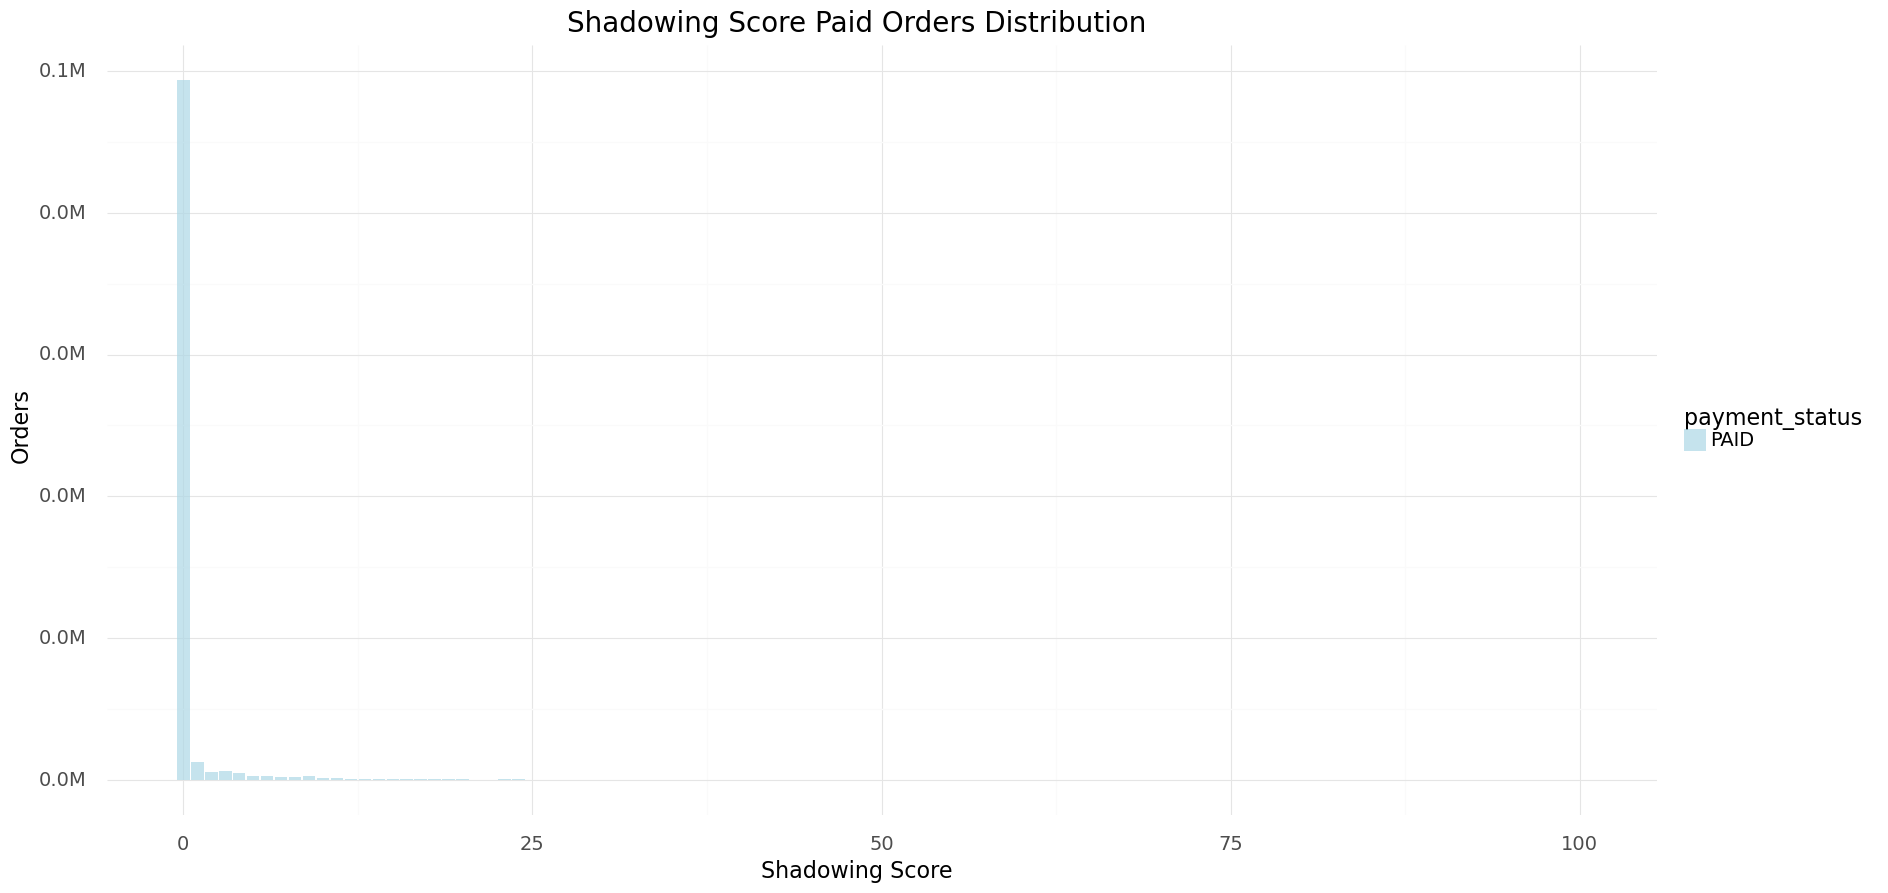

<ggplot: (676344689)>

In [43]:
(
    pn.ggplot(shadowing_score.query('payment_status=="PAID"').reset_index(drop=True)) +
    pn.geom_bar(pn.aes(x='shadowing_score', y='counts', fill="payment_status"), stat="identity", alpha=0.7) +
    pn.scale_y_continuous(name="Orders", labels=lambda l: ['{:.1f}M'.format(v / 1000000) for v in l]) +
    pn.scale_fill_manual(values={"PAID": "lightblue"}) + 
    pn.scale_x_continuous(name="Shadowing Score"#,
                         # breaks=range(int(final_df['MAX_ordersCount'].min()), int(final_df['MAX_ordersCount'].max()) + 1, 1),  # Adjust the range and step as needed
                          #labels=lambda l: ['{:.0f}'.format(v) for v in l]  # Optional formatting for x-axis labels
    ) +
    pn.theme_minimal() +
    pn.labs(title="Shadowing Score Paid Orders Distribution")+
    pn.theme(figure_size=(20, 10),  # Adjust figure size as needed
         # Adjusting title and labels size
          title=pn.element_text(size=20),  # Adjust title size
          axis_title=pn.element_text(size=16),  # Adjust axis titles size
          axis_text=pn.element_text(size=14),  # Adjust axis labels size
         # Adjusting legend title and text size
          legend_title=pn.element_text(size=16),  # Adjust legend title size
          legend_text=pn.element_text(size=14))  # Adjust legend text size
)

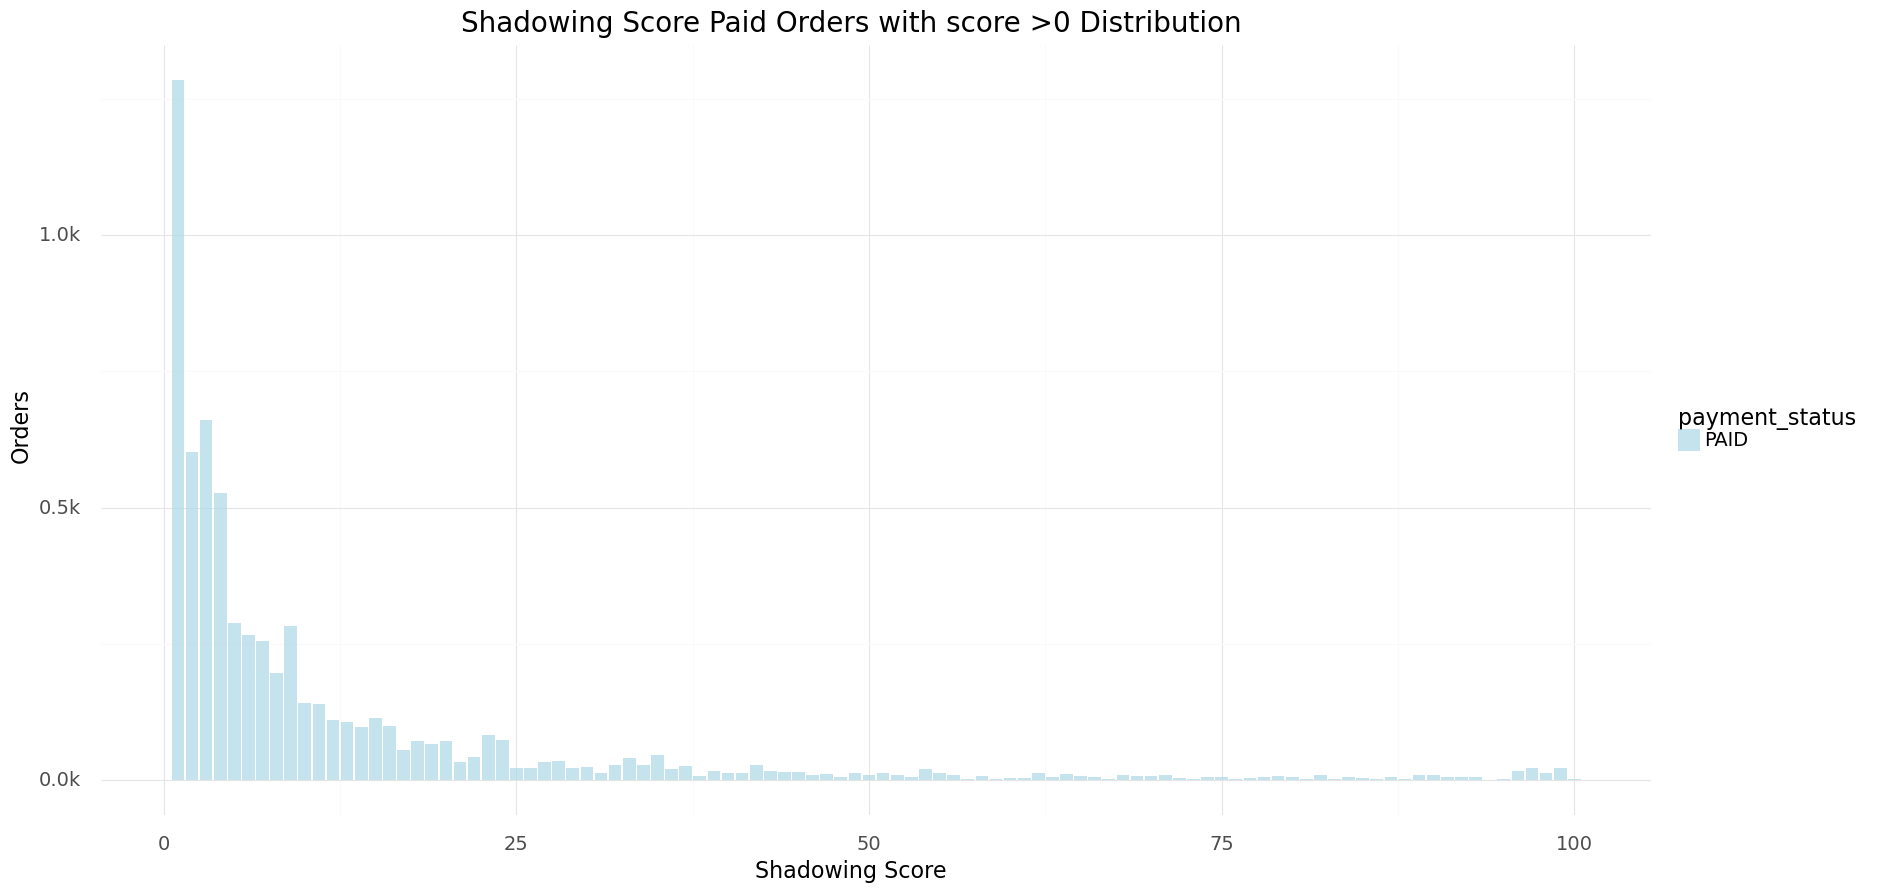

<ggplot: (676459045)>

In [44]:
(
    pn.ggplot(shadowing_score.query('payment_status=="PAID" & shadowing_score>0').reset_index(drop=True)) +
    pn.geom_bar(pn.aes(x='shadowing_score', y='counts', fill="payment_status"), stat="identity", alpha=0.7) +
    pn.scale_fill_manual(values={"PAID": "lightblue"}) + 
    pn.scale_y_continuous(name="Orders", labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]
                         ) +
    pn.scale_x_continuous(name="Shadowing Score"#,
                         # breaks=range(int(final_df['MAX_ordersCount'].min()), int(final_df['MAX_ordersCount'].max()) + 1, 1),  # Adjust the range and step as needed
                          #labels=lambda l: ['{:.0f}'.format(v) for v in l]  # Optional formatting for x-axis labels
    ) +
    pn.theme_minimal() +
    pn.labs(title="Shadowing Score Paid Orders with score >0 Distribution")+
    pn.theme(figure_size=(20, 10),  # Adjust figure size as needed
         # Adjusting title and labels size
          title=pn.element_text(size=20),  # Adjust title size
          axis_title=pn.element_text(size=16),  # Adjust axis titles size
          axis_text=pn.element_text(size=14),  # Adjust axis labels size
         # Adjusting legend title and text size
          legend_title=pn.element_text(size=16),  # Adjust legend title size
          legend_text=pn.element_text(size=14))  # Adjust legend text size
)

In [45]:
# Production Score

df_production_score=pd.DataFrame(df['production_score'].value_counts()/len(df))
df_production_score = df_production_score.reset_index()
df_production_score.columns=['production_score','percentage']
#df_production_score

In [46]:
# Shadowing Score

df_shadowing_score=pd.DataFrame(df['shadowing_score'].value_counts()/len(df))
df_shadowing_score = df_shadowing_score.reset_index()
df_shadowing_score.columns=['shadowing_score','percentage']
#df_shadowing_score

In [47]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

display_side_by_side(df_production_score,df_shadowing_score, titles=['Production Score','Shadowing Score'])

,production_score,percentage
0,0,0.927798
1,1,0.019376
2,2,0.009963
3,3,0.005903
4,4,0.005318
5,5,0.003776
6,6,0.003297
7,7,0.002358
8,8,0.002003
9,9,0.001631


# Crosstab

In [48]:
# Ground truth, the user has a successful verification and at least 1 order is a trusted user, in case not a bot.
pd.crosstab(
    df['customer_type'],
    df['payment_status'],
    dropna=False,
    normalize='all'
)

payment_status,NOT_PAID,PAID
customer_type,,
EC,0.007073,0.921593
NC,0.001897,0.069437


# Adding unpaid flag

In [50]:
df['unpaid']=df['payment_status'].apply(lambda x: 1 if x == 'NOT_PAID' else 0)

/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_89033/1840985919.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Production score evaluation

/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_89033/1154602147.py:4: RuntimeWarning: invalid value encountered in divide


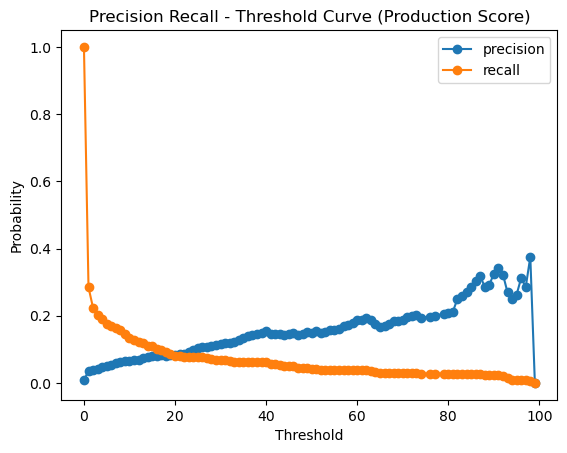

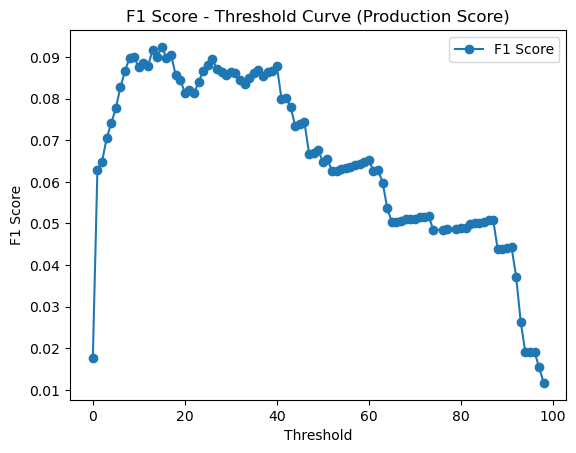

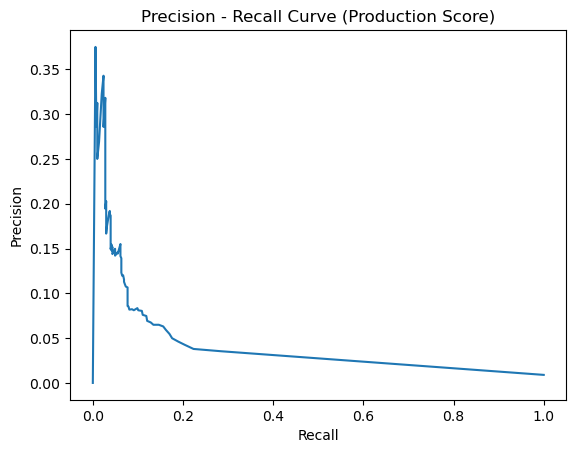

In [51]:

# Here we are looking for the precision and recall of the oposite case. 
# Case of how good is production model for detecting unpaid cash being 1 the positive label.
prec_1, recall_1, thresholds_1 = precision_recall_curve(df['unpaid'].values, df['production_score'].values, pos_label=1)
f1_scores_1 = 2 * (prec_1* recall_1) / (prec_1 + recall_1)

plt.plot(thresholds_1[:], prec_1[:-1]
         , label='precision', marker='o')
plt.plot(thresholds_1[:], recall_1[:-1], label='recall', marker='o')
plt.legend()
plt.title("Precision Recall - Threshold Curve (Production Score)")
plt.ylabel("Probability")
plt.xlabel("Threshold")

plt.figure()

plt.plot(thresholds_1[:], f1_scores_1[:-1], label='F1 Score', marker='o')
plt.legend()
plt.title("F1 Score - Threshold Curve (Production Score)")
plt.ylabel("F1 Score")
plt.xlabel("Threshold")

plt.figure()

plt.plot(recall_1[:-1], prec_1[:-1])
plt.title("Precision - Recall Curve (Production Score)")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()



#  Shadowing score evaluation

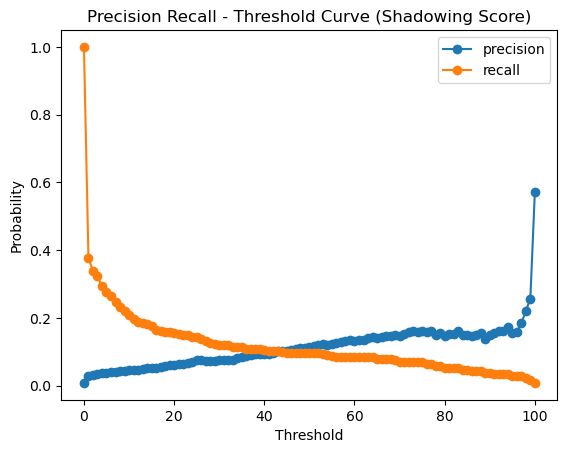

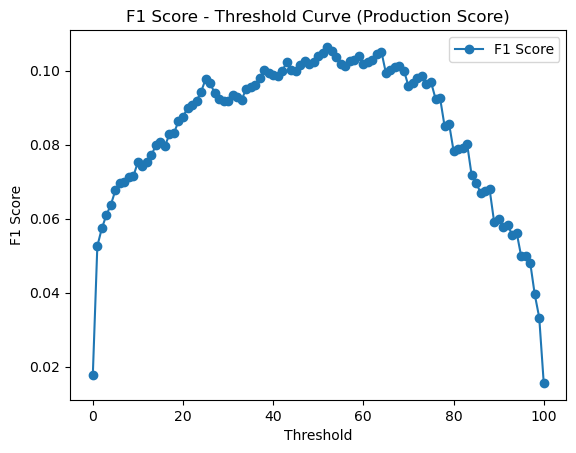

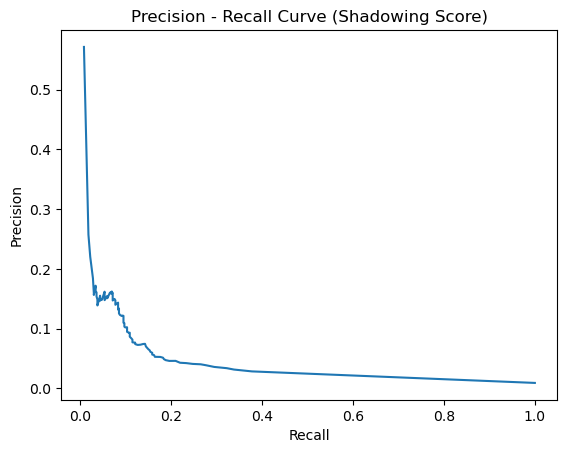

In [52]:
# Here we are looking for the precision and recall of the oposite case. 
# Case of how good is shadowing model for detecting unpaid cash being 1 the positive label.
prec_2, recall_2, thresholds_2 = precision_recall_curve(df['unpaid'].values, df['shadowing_score'].values, pos_label=1)
f1_scores_2 = 2 * (prec_2* recall_2) / (prec_2 + recall_2)

plt.plot(thresholds_2[:], prec_2[:-1], label='precision', marker='o')
plt.plot(thresholds_2[:], recall_2[:-1], label='recall', marker='o')
plt.legend()
plt.title("Precision Recall - Threshold Curve (Shadowing Score)")
plt.ylabel("Probability")
plt.xlabel("Threshold")

plt.figure()

plt.plot(thresholds_2[:], f1_scores_2[:-1], label='F1 Score', marker='o')
plt.legend()
plt.title("F1 Score - Threshold Curve (Production Score)")
plt.ylabel("F1 Score")
plt.xlabel("Threshold")


plt.figure()

plt.plot(recall_2[:-1], prec_2[:-1])
plt.title("Precision - Recall Curve (Shadowing Score)")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

# Model comparison

In [53]:
# Convert payment_status to binary where NOT_PAID is 1 and PAID is 0
df['true_label'] = df['unpaid']

/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_89033/1050085443.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_89033/47345187.py:5: RuntimeWarning: invalid value encountered in divide


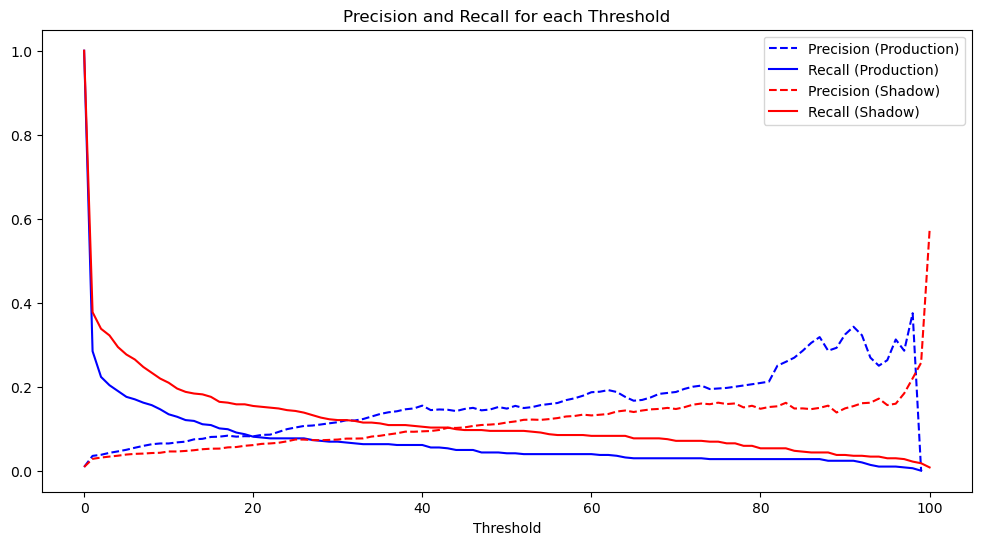

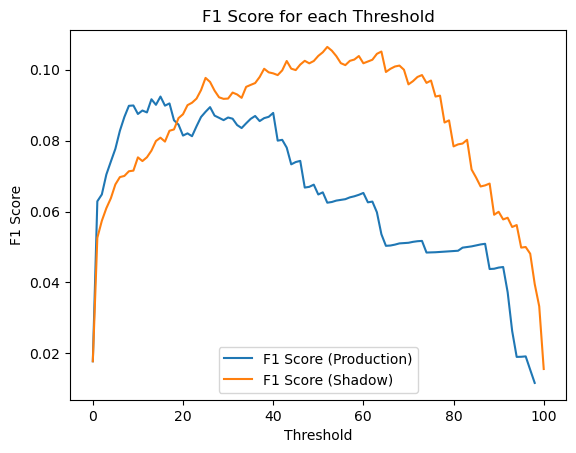

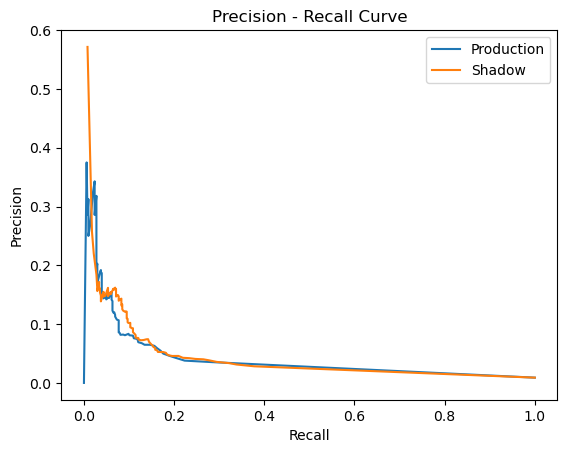

In [54]:
# Calculate precision, recall, and thresholds for each model
precision_production, recall_production, thresholds_production = precision_recall_curve(df['true_label'], df['production_score'])
precision_shadow, recall_shadow, thresholds_shadow = precision_recall_curve(df['true_label'], df['shadowing_score'])

f1_production = 2 * (precision_production* recall_production) / (precision_production + recall_production)
f1_shadow = 2 * (precision_shadow* recall_shadow) / (precision_shadow + recall_shadow)

# Plot precision and recall against the threshold for each model
plt.figure(figsize=(12, 6))

plt.plot(thresholds_production, precision_production[:-1], 'b--', label='Precision (Production)')
plt.plot(thresholds_production, recall_production[:-1], 'b-', label='Recall (Production)')
plt.plot(thresholds_shadow, precision_shadow[:-1], 'r--', label='Precision (Shadow)')
plt.plot(thresholds_shadow, recall_shadow[:-1], 'r-', label='Recall (Shadow)')
plt.xlabel('Threshold')
plt.title('Precision and Recall for each Threshold')
plt.legend()

plt.figure()

plt.plot(thresholds_production, f1_production[:-1], label='F1 Score (Production)')
plt.plot(thresholds_shadow, f1_shadow[:-1], label='F1 Score (Shadow)')
plt.legend()
plt.title("F1 Score for each Threshold")
plt.ylabel("F1 Score")
plt.xlabel("Threshold")

plt.figure()

plt.plot(recall_production[:-1], precision_production[:-1], label="Production")
plt.plot(recall_shadow[:-1], precision_shadow[:-1], label="Shadow")
plt.title("Precision - Recall Curve")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()  # This line will display the labels
plt.show()


plt.show()

# ROC Curves with AUC

Thresholds: [inf 99. 98. 97. 96. 95. 94. 93. 92. 91. 90. 89. 88. 87. 86. 84. 82. 81.
 79. 77. 74. 73. 72. 71. 70. 68. 67. 66. 65. 64. 63. 62. 61. 60. 59. 58.
 57. 56. 54. 53. 52. 51. 50. 49. 48. 47. 46. 45. 44. 43. 42. 41. 40. 39.
 38. 37. 36. 35. 34. 33. 32. 31. 30. 29. 27. 26. 25. 24. 23. 22. 21. 20.
 19. 18. 17. 16. 15. 14. 13. 12. 11. 10.  9.  8.  7.  6.  5.  4.  3.  2.
  1.  0.]
AUC: 0.6097849153331474


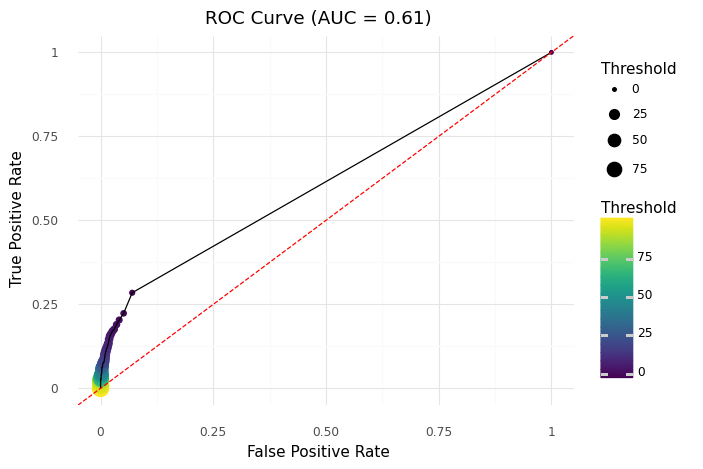

<ggplot: (676592869)>

In [55]:
# Production model
plot_roc_curve(df, preds_col='production_score', label_col='unpaid')

Thresholds: [ inf 100.  99.  98.  97.  96.  95.  94.  93.  92.  91.  90.  89.  88.
  87.  86.  85.  84.  83.  82.  81.  80.  79.  78.  77.  76.  75.  74.
  73.  72.  71.  70.  69.  68.  67.  66.  65.  64.  63.  62.  60.  59.
  58.  57.  56.  55.  54.  53.  52.  51.  50.  49.  48.  47.  46.  45.
  44.  43.  42.  41.  40.  39.  38.  37.  36.  35.  34.  33.  32.  31.
  30.  29.  28.  27.  26.  25.  24.  23.  22.  21.  20.  19.  18.  17.
  16.  15.  14.  13.  12.  11.  10.   9.   8.   7.   6.   5.   4.   3.
   2.   1.   0.]
AUC: 0.6370132597188978


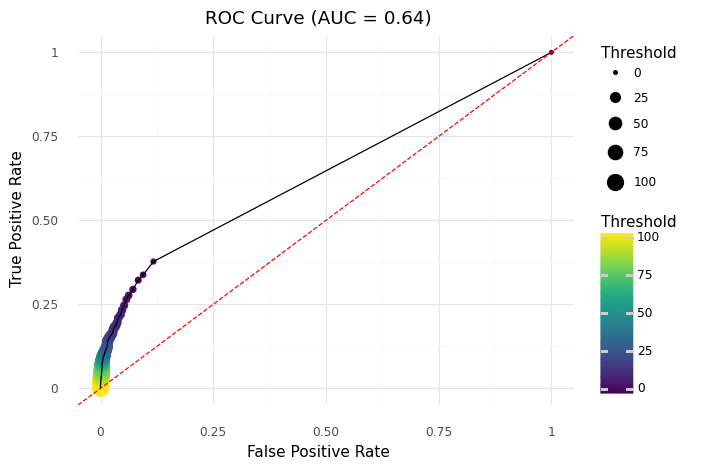

<ggplot: (676742393)>

In [56]:
# Shadowing Model
plot_roc_curve(df, preds_col='shadowing_score', label_col='unpaid')

# CASH UNPAID WITH 95% OF DATA

Because we have a smalll data set we will run to confirm assumptions with the 95% of the data, for sure we know that will be biassed from start but, we want to have a clear outcome of the expecation we must have with the retrained model

##### It is important to know that thedataset is biassed due that half ot it is not allowed to order by the current rules

In [59]:
#new query
query= f'''
SELECT DATE(DATE_TRUNC('day', rfs.p_creation_date)) AS date
        , CASE 
            WHEN CAST(json_extract_scalar(rfs.features, '$.customer.finishedOrdersCount') AS INT) = 0 THEN 'NC' 
            ELSE 'EC'
        END AS customer_type
        , rfs.risk_feature_snapshot_creation_datetime AS rfs_creation_date
        , rfs.risk_feature_snapshot_id AS id
        , rfs.customer_id
        , json_extract_scalar(rfs.features, '$.order.countryCode') AS order_country
        , json_extract_scalar(rfs.features, '$.customer.ordersCount') AS ordersCount
        , json_extract_scalar(rfs.features, '$.customer.debtOrdersCount') AS debtOrdersCount 
        
        , JSON_EXTRACT_SCALAR(rfs.features, '$.order.amountInEur.amountMajor')   AS order_amount_eur
        , JSON_EXTRACT_SCALAR(rfs.features, '$.customer.debtTotalInEur')         AS debt_amount_eur
        
        , NULLIF(json_extract_scalar(rfs.features, '$.ml.ml_uch.score'), ' ') AS production_score
        , NULLIF(json_extract_scalar(rfs.features, '$.ml.ml_uch.shadowing.ml_uch_v0.score'),' ') AS shadowing_score
        

        -- CHECKOUT 
        , co.checkout_status
        
        -- ORDERS 
        , o.order_created_at AS order_creation_date 
        , o.order_country_code
        , o.order_id
        , row_number() over (PARTITION BY o.order_id  order by o.order_created_at asc) as first_order_id -- security_check
        , o.order_cancel_reason
        , o.order_total_purchase_eur AS gmv_euros
        
        -- PAYMENTS
        , p.payment_status
        , p.payment_method
        --, p.payment_forgiven
        --, round(round(abs(p.balance) / 100.00, 2)*o.order_exchange_rate_to_eur, 2) AS p_balance_eur
        --, round(round(p.amount_paid / 100.00, 2)*o.order_exchange_rate_to_eur, 2) AS p_amount_paid_eur
        -- cm
        , cm.gmvalu_eur AS GMV_cm_table
        , cm.contribution_margin_eur 
FROM (SELECT * FROM sensitive_delta.central_risk_engine_odp.risk_feature_snapshots_enhanced WHERE TRUE 
            AND checkpoint = 'checkout' 
            AND crc32(cast ('global-cg' || cast(customer_id as varchar) as varbinary)) > (0.04 * 4294967295) 
            AND DATE(p_creation_date)>=DATE('{start_date}') AND DATE(p_creation_date)<DATE('{end_date}') 
            AND json_extract_scalar(features, '$.payment_method.type')='CASH'
            --AND NULLIF(json_extract_scalar(features, '$.ml.ml_uch.shadowing.ml_uch_v0.score'),' ') IS NOT NULL
            --AND NULLIF(json_extract_scalar(features, '$.ml.ml_uch.score'), ' ') IS NOT NULL
    ) rfs
    LEFT JOIN sensitive_delta.sensitive_fintech__checkout_orders__odp.checkout_orders co ON co.checkout_id=rfs.checkout_id AND DATE(co.p_creation_date)>=DATE('{start_date}') AND DATE(co.p_creation_date)<DATE('{end_date}')
    LEFT JOIN delta.central_order_descriptors_odp.order_descriptors_v2                 o ON o.order_id = co.order_id AND DATE(o.p_creation_date)>=DATE('{start_date}') AND DATE(o.p_creation_date)<DATE('{end_date}')
    LEFT JOIN delta.fintech_payments_odp.payments                                      p ON p.order_id = o.order_id AND DATE(p.p_creation_date)>=DATE('{start_date}') AND DATE(p.p_creation_date)<DATE('{end_date}')
    LEFT JOIN delta.finance_financial_reports_odp.pnl_order_level                     cm ON cm.order_id=o.order_id AND DATE(cm.p_creation_date)>=DATE('{start_date}') AND DATE(cm.p_creation_date)<DATE('{end_date}')  


'''


In [60]:
# To export result to pandas
with trino.dbapi.connect(**conn_details) as conn:
    df = pd.read_sql_query(query, conn)

/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_89033/1346933151.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


# EDA

In [61]:
df.dtypes

date                                    object
customer_type                           object
rfs_creation_date          datetime64[ns, UTC]
id                                       int64
customer_id                              int64
order_country                           object
ordersCount                             object
debtOrdersCount                         object
order_amount_eur                        object
debt_amount_eur                         object
production_score                        object
shadowing_score                         object
checkout_status                         object
order_creation_date        datetime64[ns, UTC]
order_country_code                      object
order_id                               float64
first_order_id                           int64
order_cancel_reason                     object
gmv_euros                              float64
payment_status                          object
payment_method                          object
GMV_cm_table 

In [62]:
len(df)

1309397

In [63]:
df.isna().sum()

date                             0
customer_type                    0
rfs_creation_date                0
id                               0
customer_id                      0
order_country                    0
ordersCount                      0
debtOrdersCount                  0
order_amount_eur                 0
debt_amount_eur                  0
production_score              5353
shadowing_score               5675
checkout_status                410
order_creation_date          34407
order_country_code           34407
order_id                     34407
first_order_id                   0
order_cancel_reason        1269844
gmv_euros                    34408
payment_status               34407
payment_method               34407
GMV_cm_table                 34414
contribution_margin_eur      34414
dtype: int64

In [64]:
df['order_id'].isna().sum()/len(df)

0.026276980930917057

### NOTE
1% of the CG does not have an order, probably this because was affected or blocked by RE rules that do not consider the exclusion of the CG 

In [65]:
df['date']=pd.to_datetime(df['date'])
df['debtOrdersCount']=df['debtOrdersCount'].astype('int64')
df['order_amount_eur']=df['order_amount_eur'].astype('float64')
df['debt_amount_eur']=df['debt_amount_eur'].astype('float64')
df['production_score'] = df['production_score'].fillna('0')
df['shadowing_score'] = df['shadowing_score'].fillna('0')
df2=df.copy()
df = df.dropna(subset=['order_id'])

In [66]:
orders = df[['date', 'payment_status']].groupby(
    ['payment_status', pd.Grouper(key='date', freq='1D')]
    ).agg(
        counts = ('date', 'count')
    ).reset_index()

In [67]:
orders['payment_status'] = orders['payment_status'].astype('category')

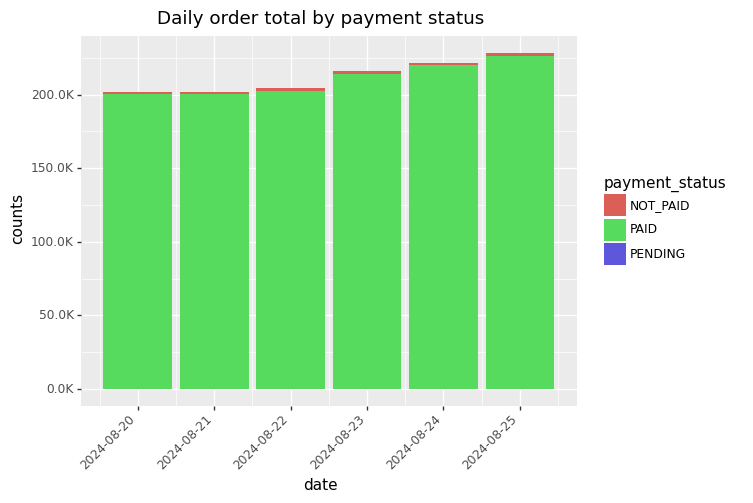

<ggplot: (767758413)>

In [68]:
# Daily Captcha calls without null score plot
(
    pn.ggplot(orders.reset_index(), pn.aes(x='date', y='counts', fill='payment_status')) +
    pn.geom_col() +
    pn.ggtitle('Daily order total by payment status') + 
    pn.scale_y_continuous(labels=lambda l: ['{:.1f}K'.format(v / 1000) for v in l]) +
    pn.theme(axis_text_x=pn.element_text(rotation=45, hjust=1)) 
    #+
    #pn.scale_fill_manual(values=['red', 'blue'])
)

# Production Score Distribution

In [69]:
df['production_score']=df['production_score'].astype('int64')

In [70]:
production_score=df.groupby(
        ['production_score','payment_status'],
        as_index=False
    ).agg(
        counts=('production_score', 'count')
    ).reset_index()

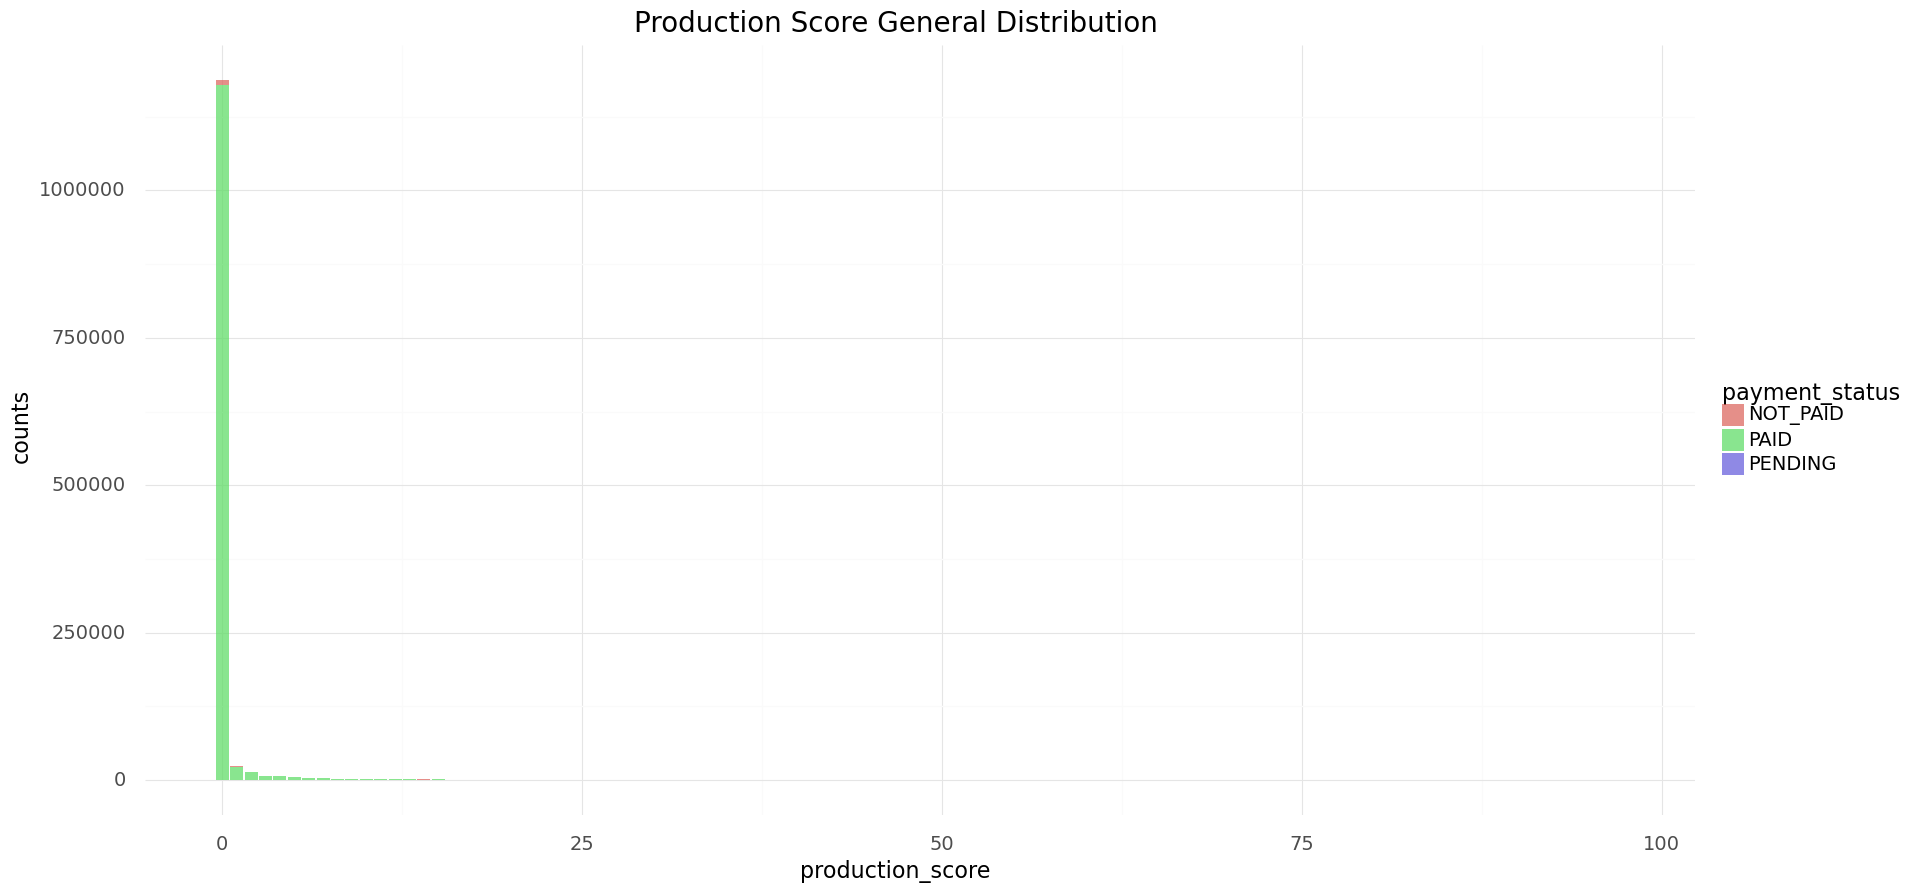

<ggplot: (767457041)>

In [71]:
(pn.ggplot(production_score) +
    pn.geom_bar(pn.aes(x='production_score', y='counts', fill="payment_status"), stat="identity", alpha=0.7) +
    #pn.scale_y_continuous(name="Orders", labels=lambda l: ['{:.1f}M'.format(v / 1000000) for v in l]) +
    #pn.scale_x_continuous(name="Production Score"#,
                         # breaks=range(int(final_df['MAX_ordersCount'].min()), int(final_df['MAX_ordersCount'].max()) + 1, 1),  # Adjust the range and step as needed
                          #labels=lambda l: ['{:.0f}'.format(v) for v in l]  # Optional formatting for x-axis labels
    #) +
    pn.theme_minimal() +
    pn.labs(title="Production Score General Distribution")+
    pn.theme(figure_size=(20, 10),  # Adjust figure size as needed
         # Adjusting title and labels size
          title=pn.element_text(size=20),  # Adjust title size
          axis_title=pn.element_text(size=16),  # Adjust axis titles size
          axis_text=pn.element_text(size=14),  # Adjust axis labels size
         # Adjusting legend title and text size
          legend_title=pn.element_text(size=16),  # Adjust legend title size
          legend_text=pn.element_text(size=14))  # Adjust legend text size
)

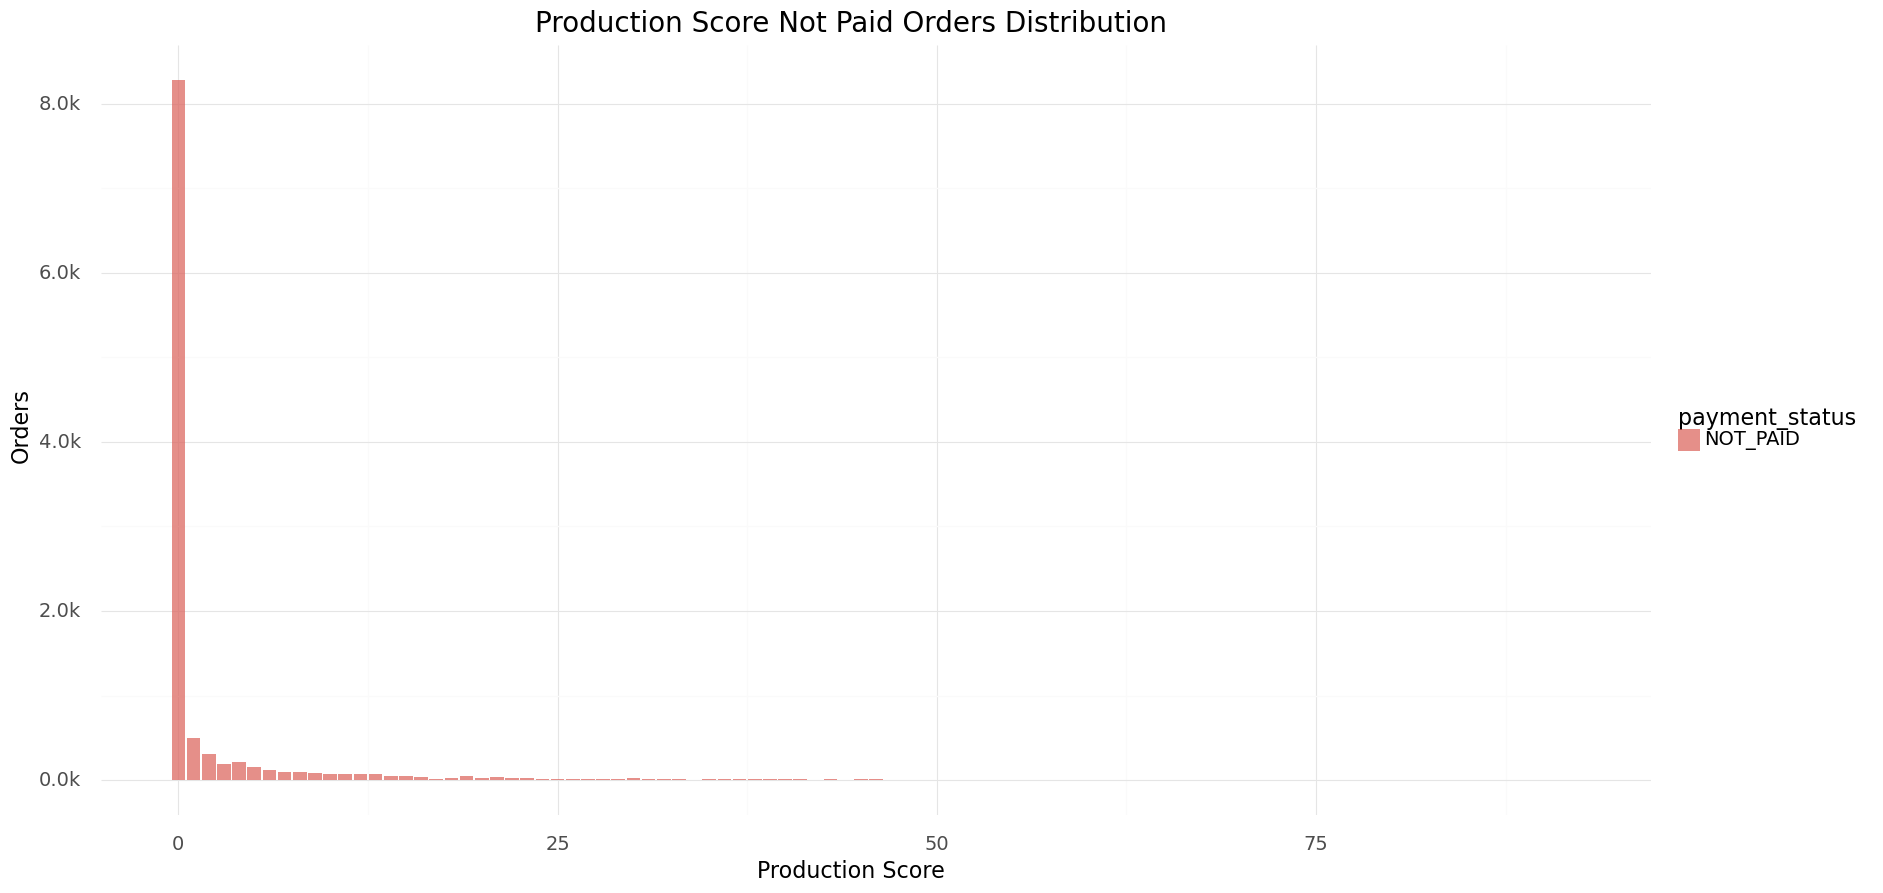

<ggplot: (767430753)>

In [72]:
(
    pn.ggplot(production_score.query('payment_status=="NOT_PAID"').reset_index(drop=True)) +
    pn.geom_bar(pn.aes(x='production_score', y='counts', fill="payment_status"), stat="identity", alpha=0.7) +
    pn.scale_y_continuous(name="Orders", labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]) +
    pn.scale_x_continuous(name="Production Score"#,
                         # breaks=range(int(final_df['MAX_ordersCount'].min()), int(final_df['MAX_ordersCount'].max()) + 1, 1),  # Adjust the range and step as needed
                          #labels=lambda l: ['{:.0f}'.format(v) for v in l]  # Optional formatting for x-axis labels
    ) +
    pn.theme_minimal() +
    pn.labs(title="Production Score Not Paid Orders Distribution")+
    pn.theme(figure_size=(20, 10),  # Adjust figure size as needed
         # Adjusting title and labels size
          title=pn.element_text(size=20),  # Adjust title size
          axis_title=pn.element_text(size=16),  # Adjust axis titles size
          axis_text=pn.element_text(size=14),  # Adjust axis labels size
         # Adjusting legend title and text size
          legend_title=pn.element_text(size=16),  # Adjust legend title size
          legend_text=pn.element_text(size=14))  # Adjust legend text size
)

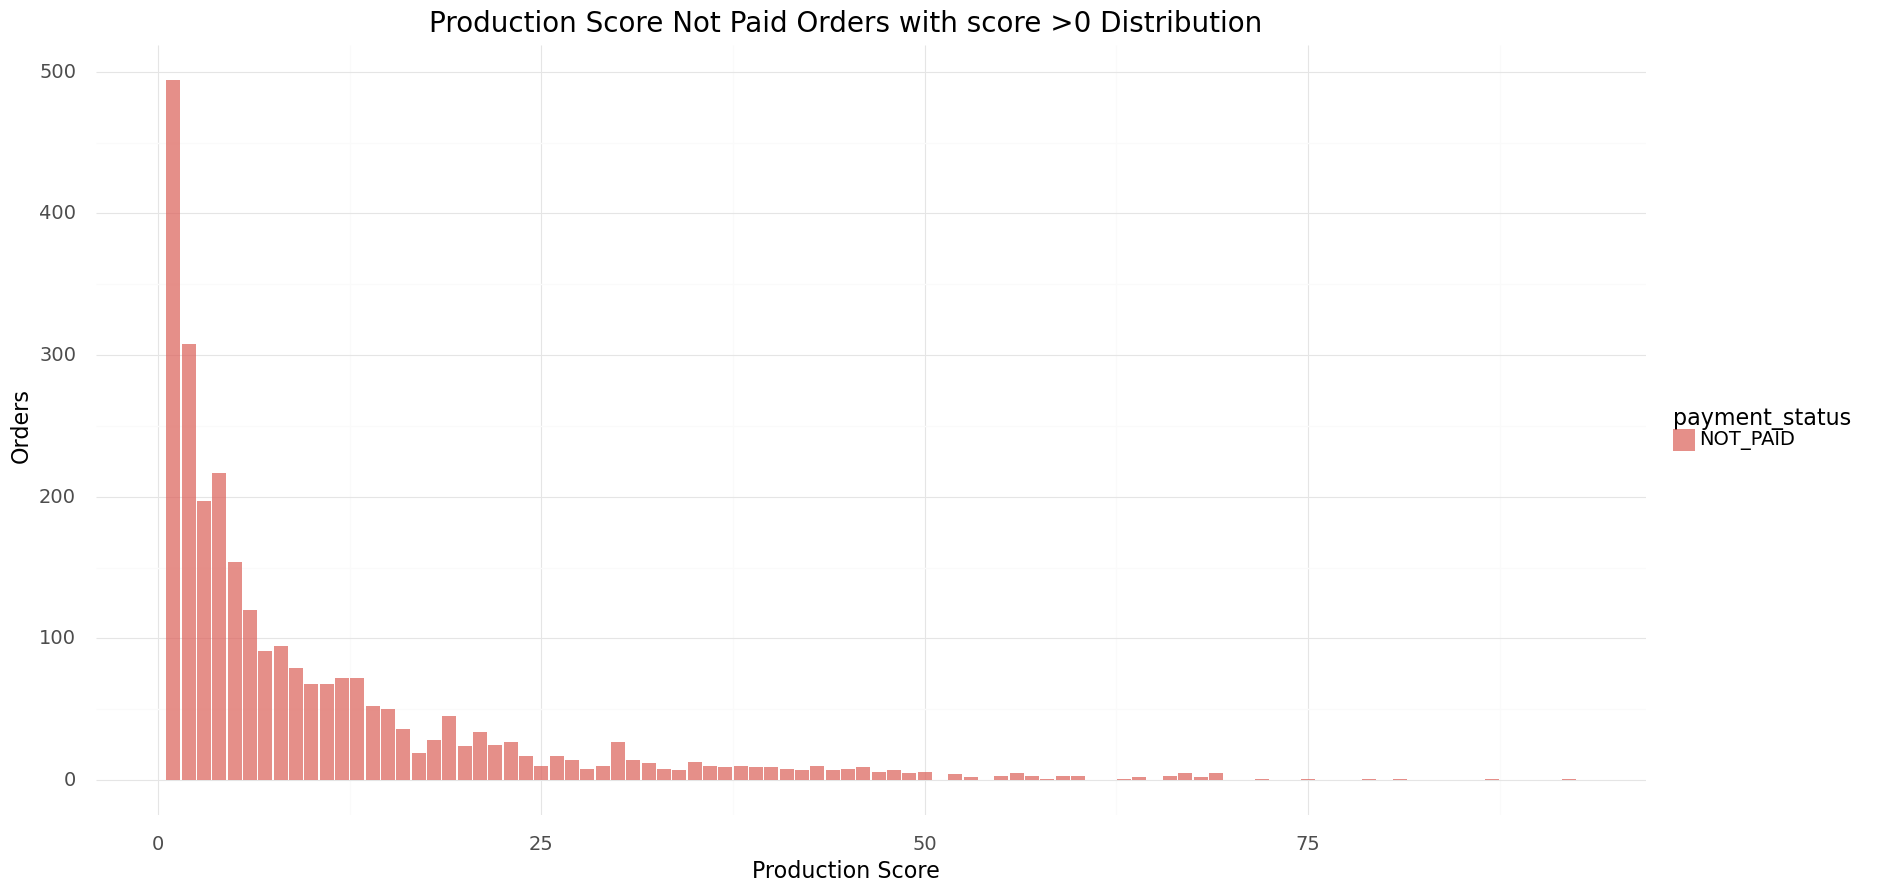

<ggplot: (767326465)>

In [73]:
(
    pn.ggplot(production_score.query('payment_status=="NOT_PAID" & production_score>0').reset_index(drop=True)) +
    pn.geom_bar(pn.aes(x='production_score', y='counts', fill="payment_status"), stat="identity", alpha=0.7) +
    pn.scale_y_continuous(name="Orders"#, labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]
                         ) +
    pn.scale_x_continuous(name="Production Score"#,
                         # breaks=range(int(final_df['MAX_ordersCount'].min()), int(final_df['MAX_ordersCount'].max()) + 1, 1),  # Adjust the range and step as needed
                          #labels=lambda l: ['{:.0f}'.format(v) for v in l]  # Optional formatting for x-axis labels
    ) +
    pn.theme_minimal() +
    pn.labs(title="Production Score Not Paid Orders with score >0 Distribution")+
    pn.theme(figure_size=(20, 10),  # Adjust figure size as needed
         # Adjusting title and labels size
          title=pn.element_text(size=20),  # Adjust title size
          axis_title=pn.element_text(size=16),  # Adjust axis titles size
          axis_text=pn.element_text(size=14),  # Adjust axis labels size
         # Adjusting legend title and text size
          legend_title=pn.element_text(size=16),  # Adjust legend title size
          legend_text=pn.element_text(size=14))  # Adjust legend text size
)

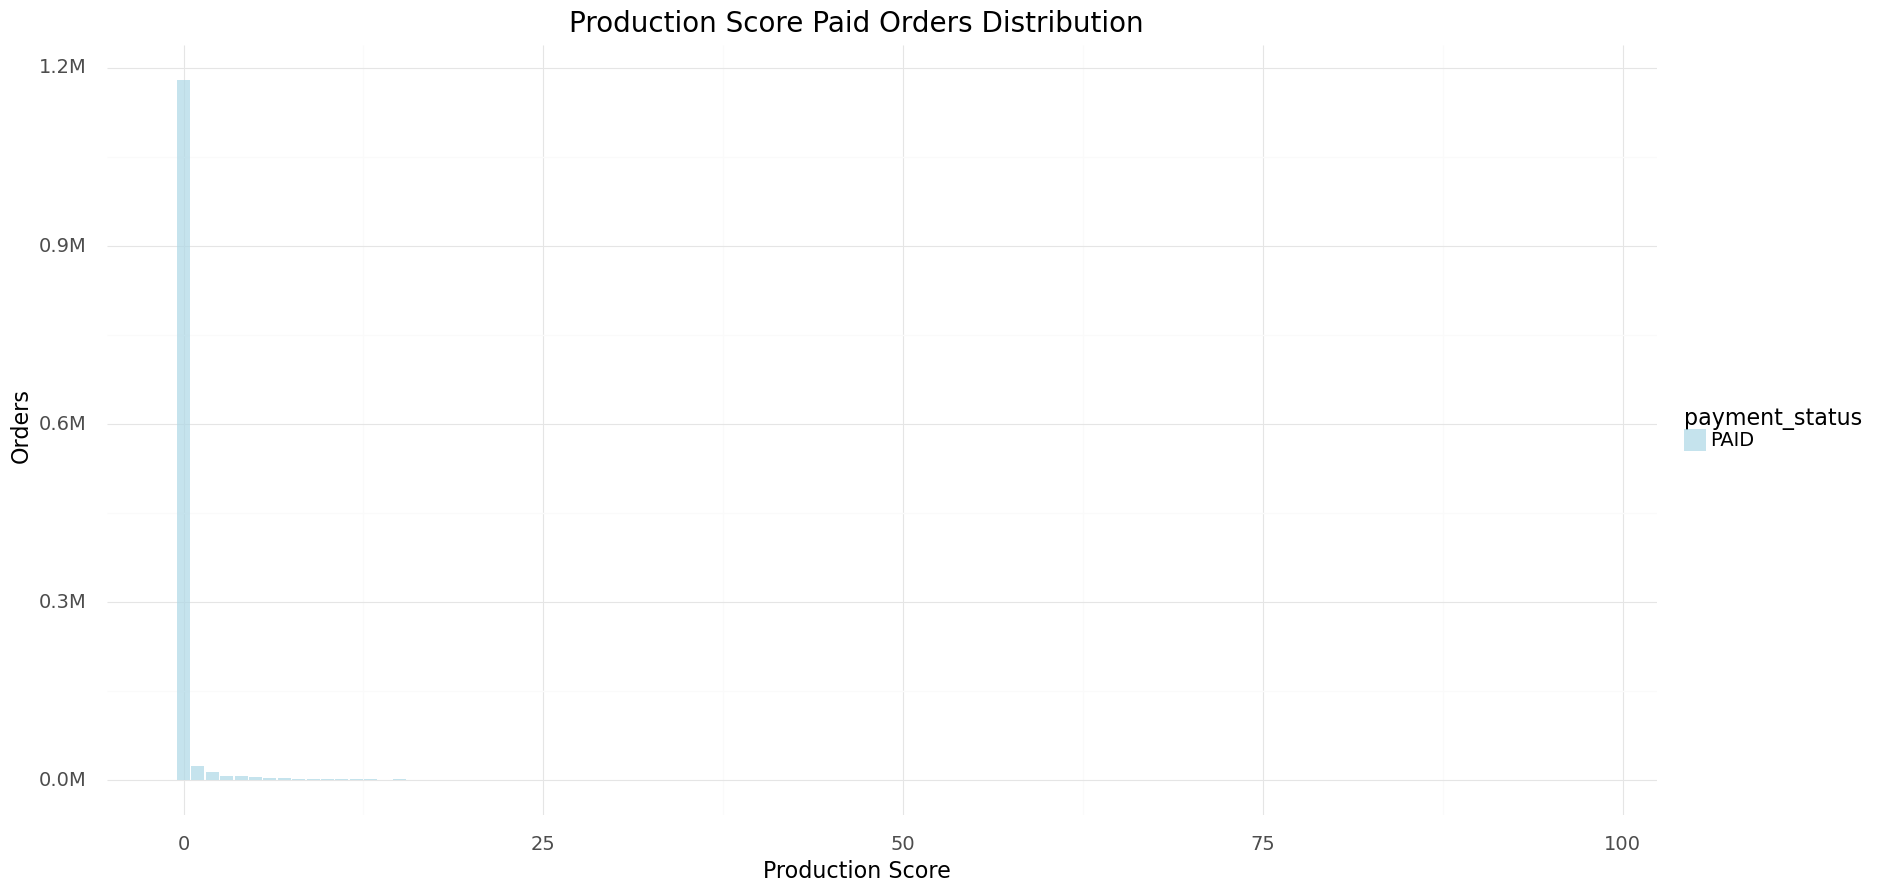

<ggplot: (767443197)>

In [74]:
(
    pn.ggplot(production_score.query('payment_status=="PAID"').reset_index(drop=True)) +
    pn.geom_bar(pn.aes(x='production_score', y='counts', fill="payment_status"), stat="identity", alpha=0.7) +
    pn.scale_y_continuous(name="Orders", labels=lambda l: ['{:.1f}M'.format(v / 1000000) for v in l]) +
    pn.scale_fill_manual(values={"PAID": "lightblue"}) + 
    pn.scale_x_continuous(name="Production Score"#,
                         # breaks=range(int(final_df['MAX_ordersCount'].min()), int(final_df['MAX_ordersCount'].max()) + 1, 1),  # Adjust the range and step as needed
                          #labels=lambda l: ['{:.0f}'.format(v) for v in l]  # Optional formatting for x-axis labels
    ) +
    pn.theme_minimal() +
    pn.labs(title="Production Score Paid Orders Distribution")+
    pn.theme(figure_size=(20, 10),  # Adjust figure size as needed
         # Adjusting title and labels size
          title=pn.element_text(size=20),  # Adjust title size
          axis_title=pn.element_text(size=16),  # Adjust axis titles size
          axis_text=pn.element_text(size=14),  # Adjust axis labels size
         # Adjusting legend title and text size
          legend_title=pn.element_text(size=16),  # Adjust legend title size
          legend_text=pn.element_text(size=14))  # Adjust legend text size
)

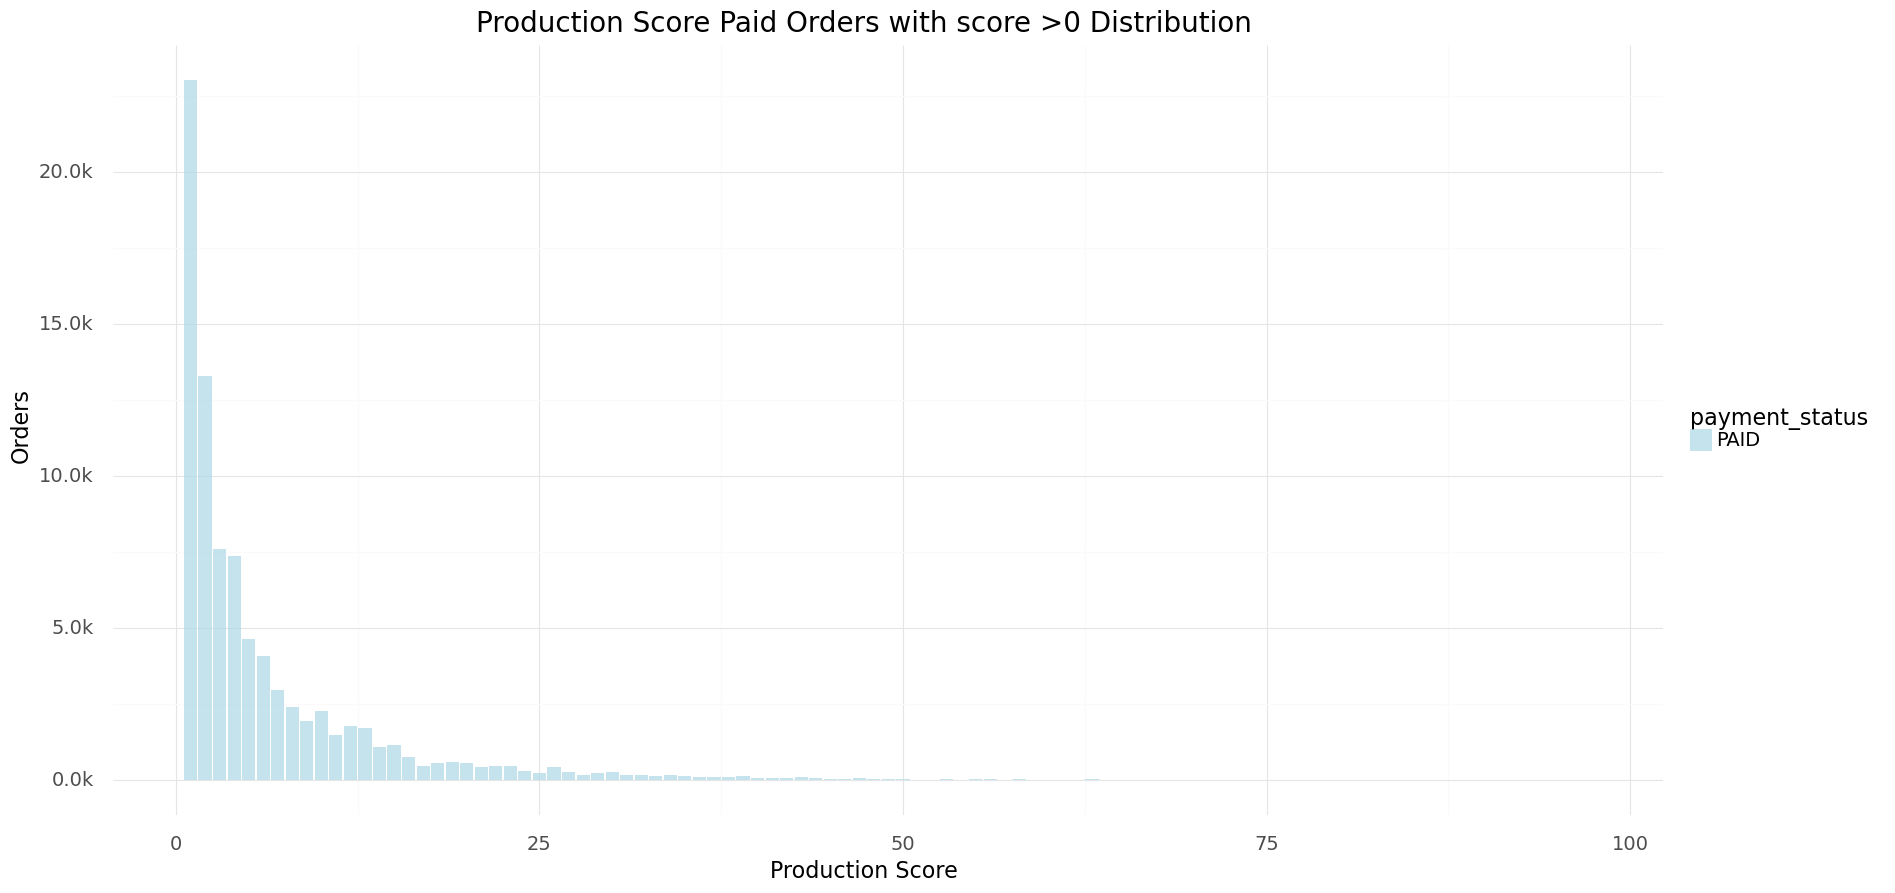

<ggplot: (767875973)>

In [75]:
(
    pn.ggplot(production_score.query('payment_status=="PAID" & production_score>0').reset_index(drop=True)) +
    pn.geom_bar(pn.aes(x='production_score', y='counts', fill="payment_status"), stat="identity", alpha=0.7) +
    pn.scale_fill_manual(values={"PAID": "lightblue"}) + 
    pn.scale_y_continuous(name="Orders", labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]
                         ) +
    pn.scale_x_continuous(name="Production Score"#,
                         # breaks=range(int(final_df['MAX_ordersCount'].min()), int(final_df['MAX_ordersCount'].max()) + 1, 1),  # Adjust the range and step as needed
                          #labels=lambda l: ['{:.0f}'.format(v) for v in l]  # Optional formatting for x-axis labels
    ) +
    pn.theme_minimal() +
    pn.labs(title="Production Score Paid Orders with score >0 Distribution")+
    pn.theme(figure_size=(20, 10),  # Adjust figure size as needed
         # Adjusting title and labels size
          title=pn.element_text(size=20),  # Adjust title size
          axis_title=pn.element_text(size=16),  # Adjust axis titles size
          axis_text=pn.element_text(size=14),  # Adjust axis labels size
         # Adjusting legend title and text size
          legend_title=pn.element_text(size=16),  # Adjust legend title size
          legend_text=pn.element_text(size=14))  # Adjust legend text size
)

# Shadowing Score Distribution

In [76]:
df['shadowing_score']=df['shadowing_score'].astype('int64')

In [77]:
shadowing_score=df.groupby(
        ['shadowing_score','payment_status'],
        as_index=False
    ).agg(
        counts=('shadowing_score', 'count')
    ).reset_index()

shadowing_score['shadowing_score'] = pd.to_numeric(shadowing_score['shadowing_score'], errors='coerce')

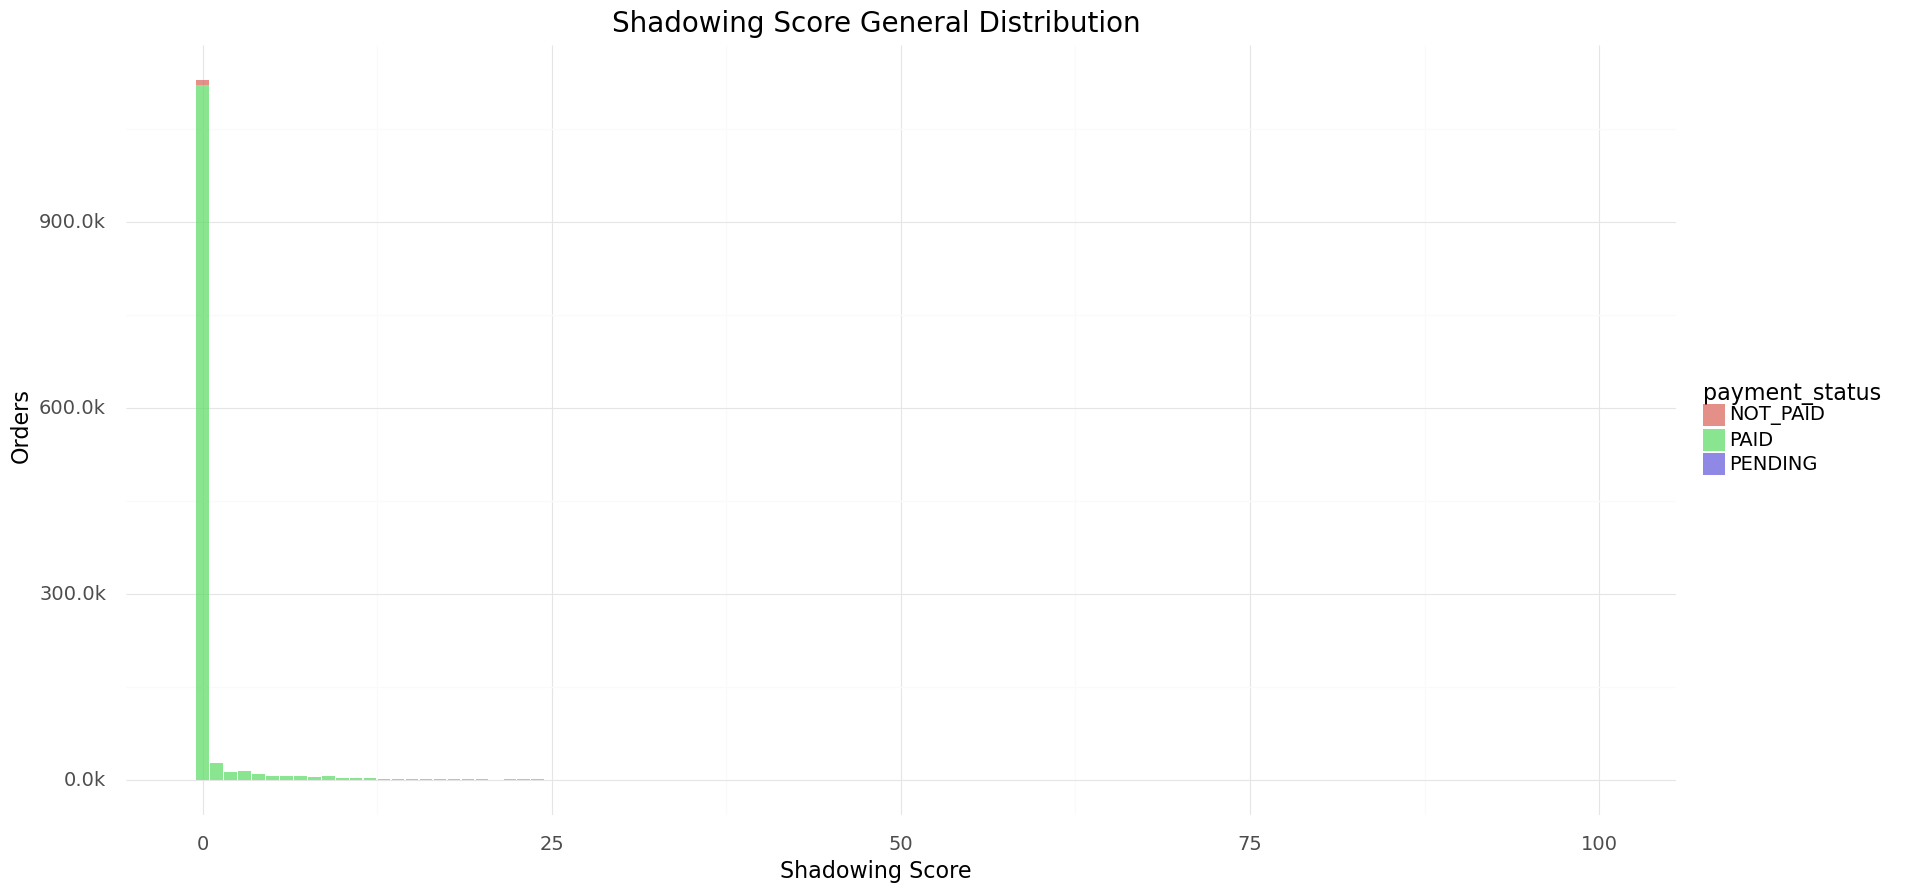

<ggplot: (766351993)>

In [78]:
(
    pn.ggplot(shadowing_score) +
    pn.geom_bar(pn.aes(x='shadowing_score', y='counts', fill="payment_status"), stat="identity", alpha=0.7) +
    pn.scale_y_continuous(name="Orders", labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]) +
    pn.scale_x_continuous(name="Shadowing Score"#,
                         # breaks=range(int(final_df['MAX_ordersCount'].min()), int(final_df['MAX_ordersCount'].max()) + 1, 1),  # Adjust the range and step as needed
                          #labels=lambda l: ['{:.0f}'.format(v) for v in l]  # Optional formatting for x-axis labels
    ) +
    pn.theme_minimal() +
    pn.labs(title="Shadowing Score General Distribution")+
    pn.theme(figure_size=(20, 10),  # Adjust figure size as needed
         # Adjusting title and labels size
          title=pn.element_text(size=20),  # Adjust title size
          axis_title=pn.element_text(size=16),  # Adjust axis titles size
          axis_text=pn.element_text(size=14),  # Adjust axis labels size
         # Adjusting legend title and text size
          legend_title=pn.element_text(size=16),  # Adjust legend title size
          legend_text=pn.element_text(size=14))  # Adjust legend text size
)


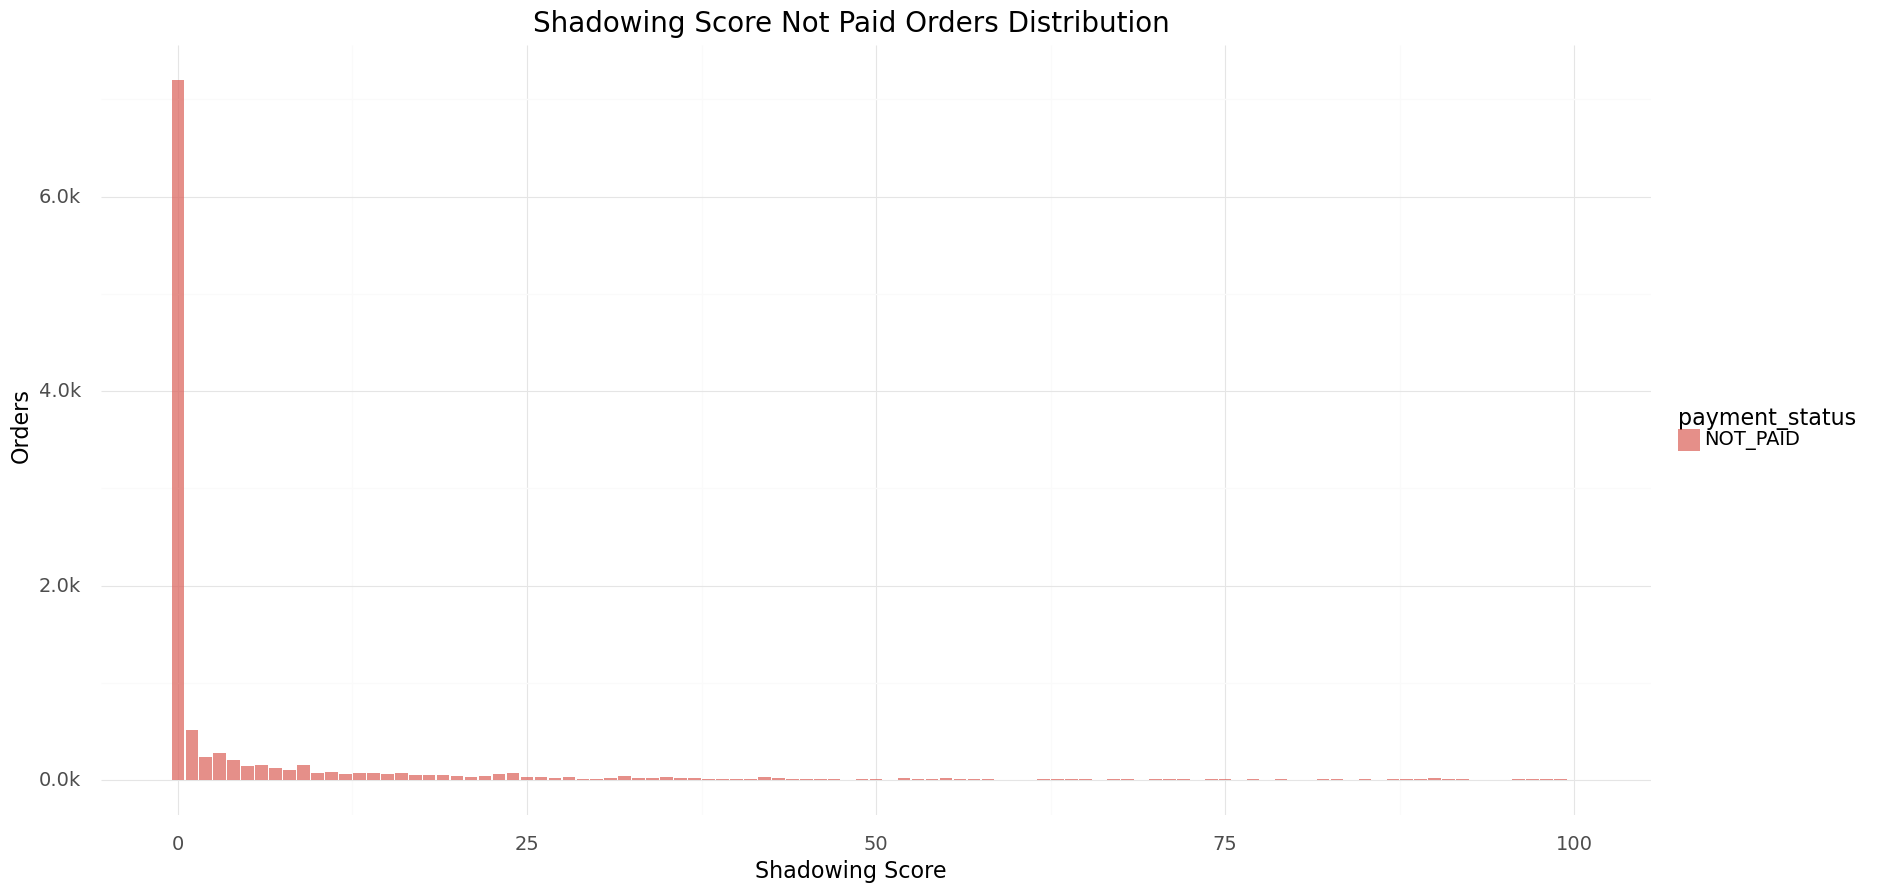

<ggplot: (766514293)>

In [79]:
(
    pn.ggplot(shadowing_score.query('payment_status=="NOT_PAID"').reset_index(drop=True)) +
    pn.geom_bar(pn.aes(x='shadowing_score', y='counts', fill="payment_status"), stat="identity", alpha=0.7) +
    pn.scale_y_continuous(name="Orders", labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]) +
    pn.scale_x_continuous(name="Shadowing Score"#,
                         # breaks=range(int(final_df['MAX_ordersCount'].min()), int(final_df['MAX_ordersCount'].max()) + 1, 1),  # Adjust the range and step as needed
                          #labels=lambda l: ['{:.0f}'.format(v) for v in l]  # Optional formatting for x-axis labels
    ) +
    pn.theme_minimal() +
    pn.labs(title="Shadowing Score Not Paid Orders Distribution")+
    pn.theme(figure_size=(20, 10),  # Adjust figure size as needed
         # Adjusting title and labels size
          title=pn.element_text(size=20),  # Adjust title size
          axis_title=pn.element_text(size=16),  # Adjust axis titles size
          axis_text=pn.element_text(size=14),  # Adjust axis labels size
         # Adjusting legend title and text size
          legend_title=pn.element_text(size=16),  # Adjust legend title size
          legend_text=pn.element_text(size=14))  # Adjust legend text size
)

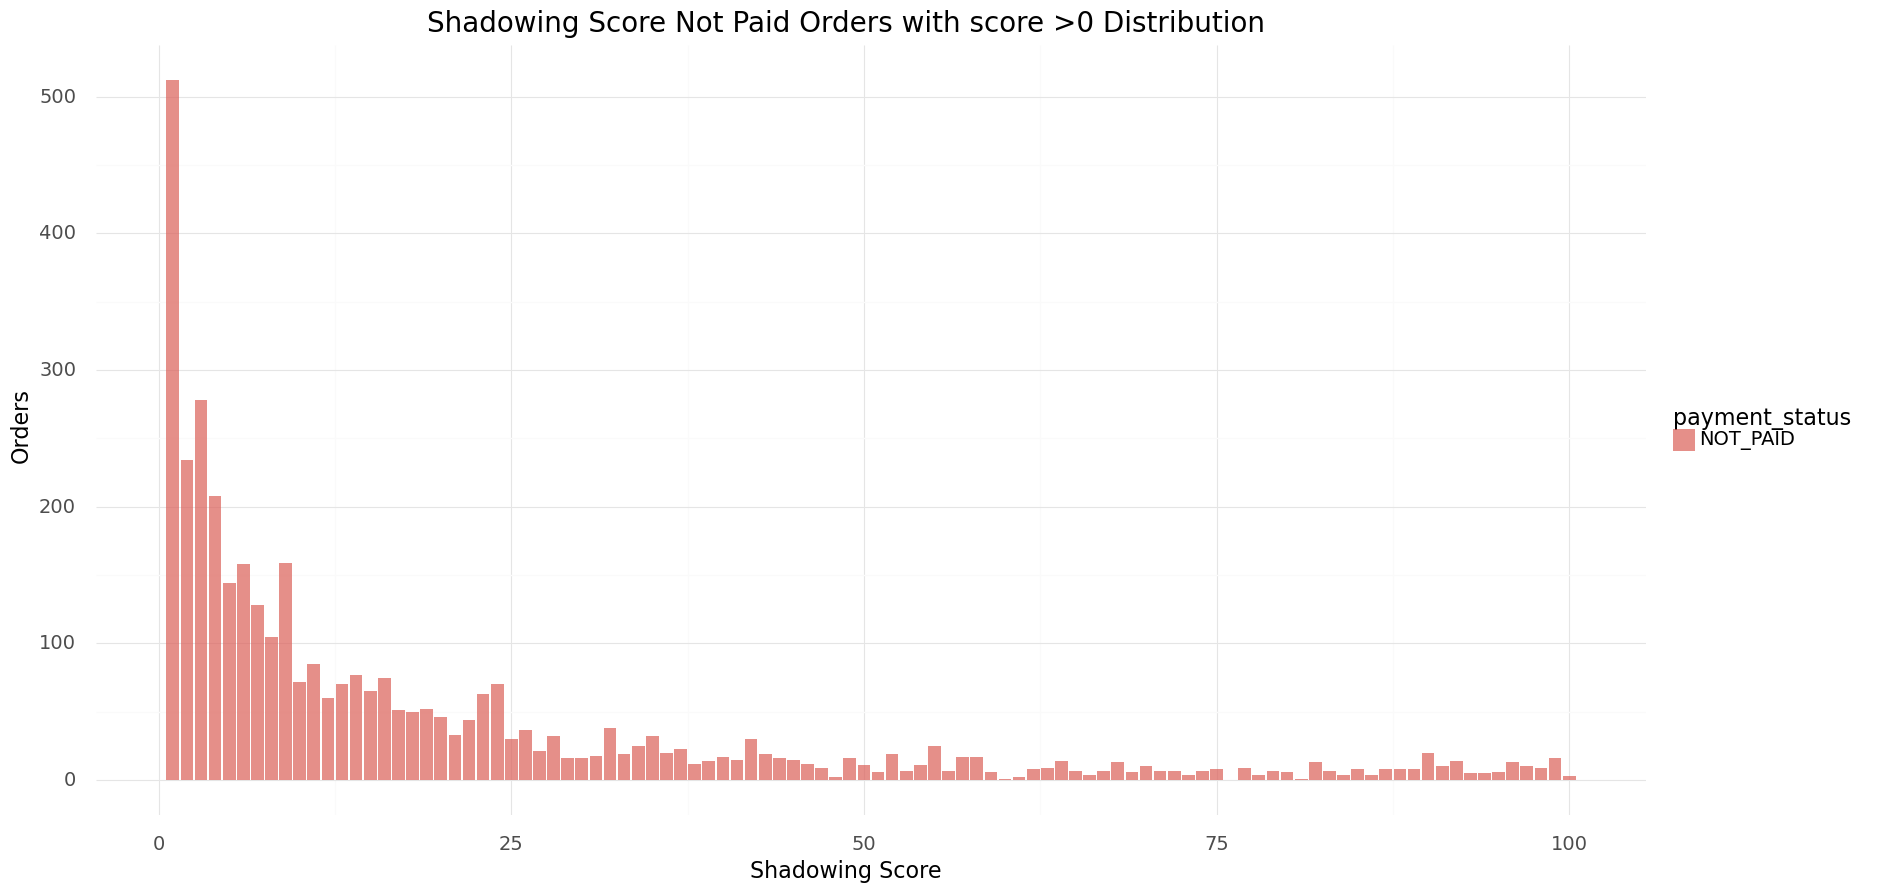

<ggplot: (765925725)>

In [80]:
(
    pn.ggplot(shadowing_score.query('payment_status=="NOT_PAID" & shadowing_score>0').reset_index(drop=True)) +
    pn.geom_bar(pn.aes(x='shadowing_score', y='counts', fill="payment_status"), stat="identity", alpha=0.7) +
    pn.scale_y_continuous(name="Orders"#, labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]
                         ) +
    pn.scale_x_continuous(name="Shadowing Score"#,
                         # breaks=range(int(final_df['MAX_ordersCount'].min()), int(final_df['MAX_ordersCount'].max()) + 1, 1),  # Adjust the range and step as needed
                          #labels=lambda l: ['{:.0f}'.format(v) for v in l]  # Optional formatting for x-axis labels
    ) +
    pn.theme_minimal() +
    pn.labs(title="Shadowing Score Not Paid Orders with score >0 Distribution")+
    pn.theme(figure_size=(20, 10),  # Adjust figure size as needed
         # Adjusting title and labels size
          title=pn.element_text(size=20),  # Adjust title size
          axis_title=pn.element_text(size=16),  # Adjust axis titles size
          axis_text=pn.element_text(size=14),  # Adjust axis labels size
         # Adjusting legend title and text size
          legend_title=pn.element_text(size=16),  # Adjust legend title size
          legend_text=pn.element_text(size=14))  # Adjust legend text size
)

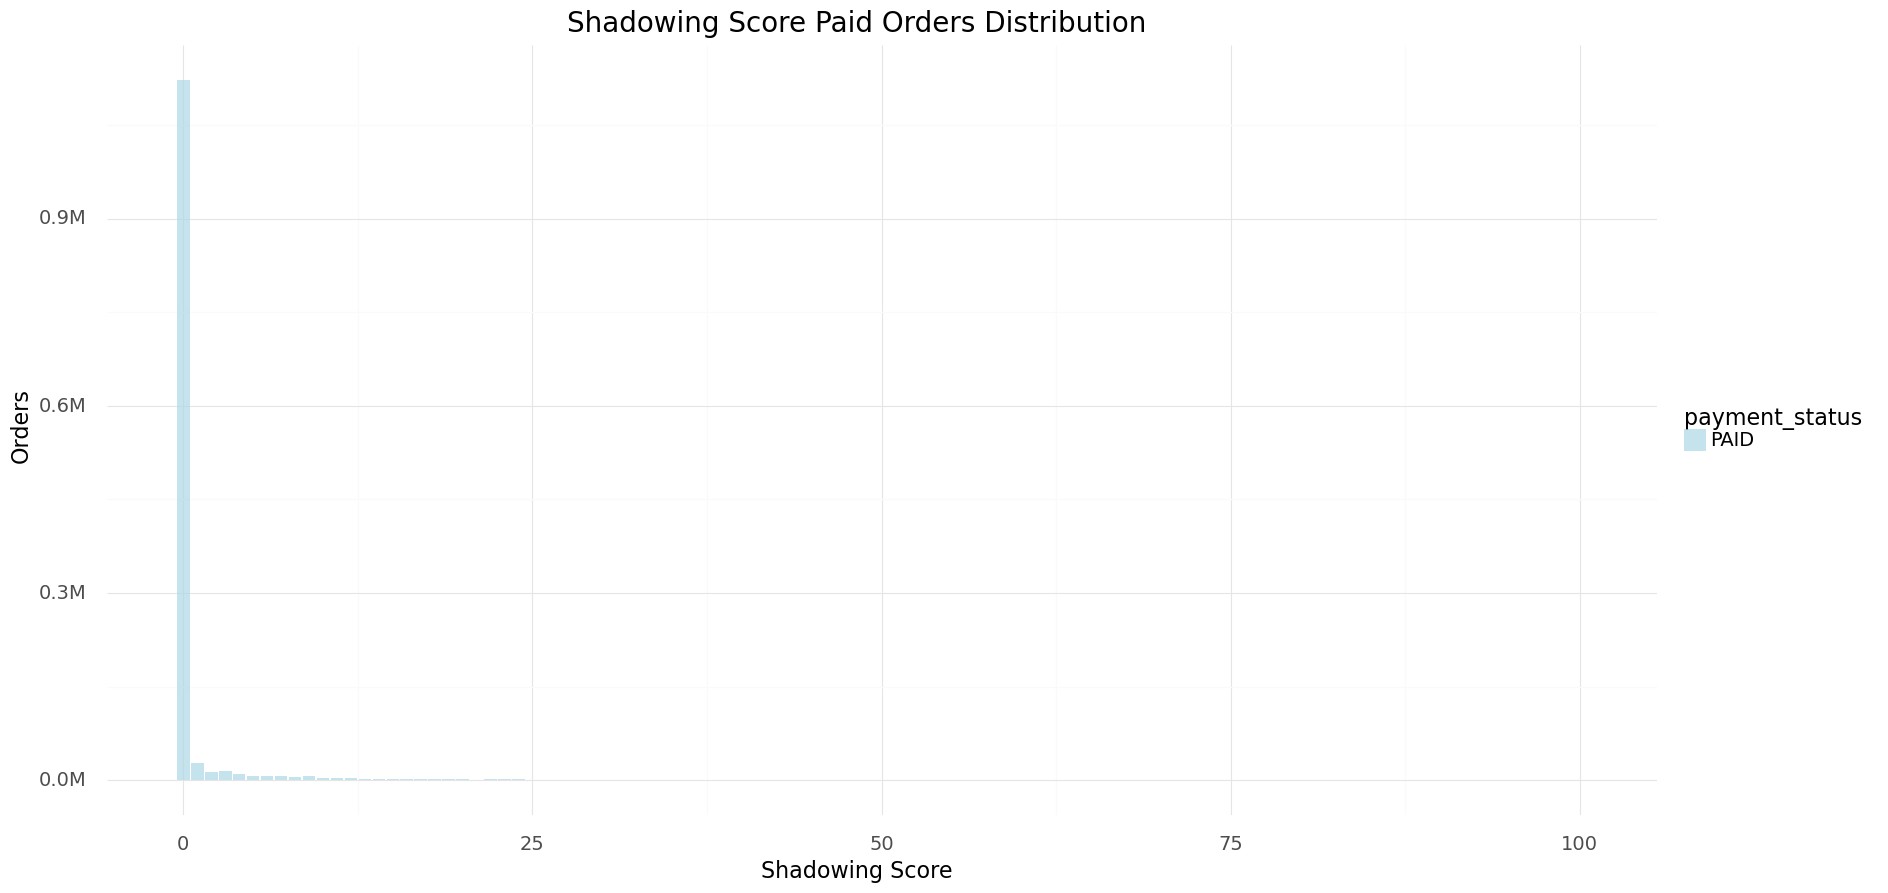

<ggplot: (765543081)>

In [81]:
(
    pn.ggplot(shadowing_score.query('payment_status=="PAID"').reset_index(drop=True)) +
    pn.geom_bar(pn.aes(x='shadowing_score', y='counts', fill="payment_status"), stat="identity", alpha=0.7) +
    pn.scale_y_continuous(name="Orders", labels=lambda l: ['{:.1f}M'.format(v / 1000000) for v in l]) +
    pn.scale_fill_manual(values={"PAID": "lightblue"}) + 
    pn.scale_x_continuous(name="Shadowing Score"#,
                         # breaks=range(int(final_df['MAX_ordersCount'].min()), int(final_df['MAX_ordersCount'].max()) + 1, 1),  # Adjust the range and step as needed
                          #labels=lambda l: ['{:.0f}'.format(v) for v in l]  # Optional formatting for x-axis labels
    ) +
    pn.theme_minimal() +
    pn.labs(title="Shadowing Score Paid Orders Distribution")+
    pn.theme(figure_size=(20, 10),  # Adjust figure size as needed
         # Adjusting title and labels size
          title=pn.element_text(size=20),  # Adjust title size
          axis_title=pn.element_text(size=16),  # Adjust axis titles size
          axis_text=pn.element_text(size=14),  # Adjust axis labels size
         # Adjusting legend title and text size
          legend_title=pn.element_text(size=16),  # Adjust legend title size
          legend_text=pn.element_text(size=14))  # Adjust legend text size
)

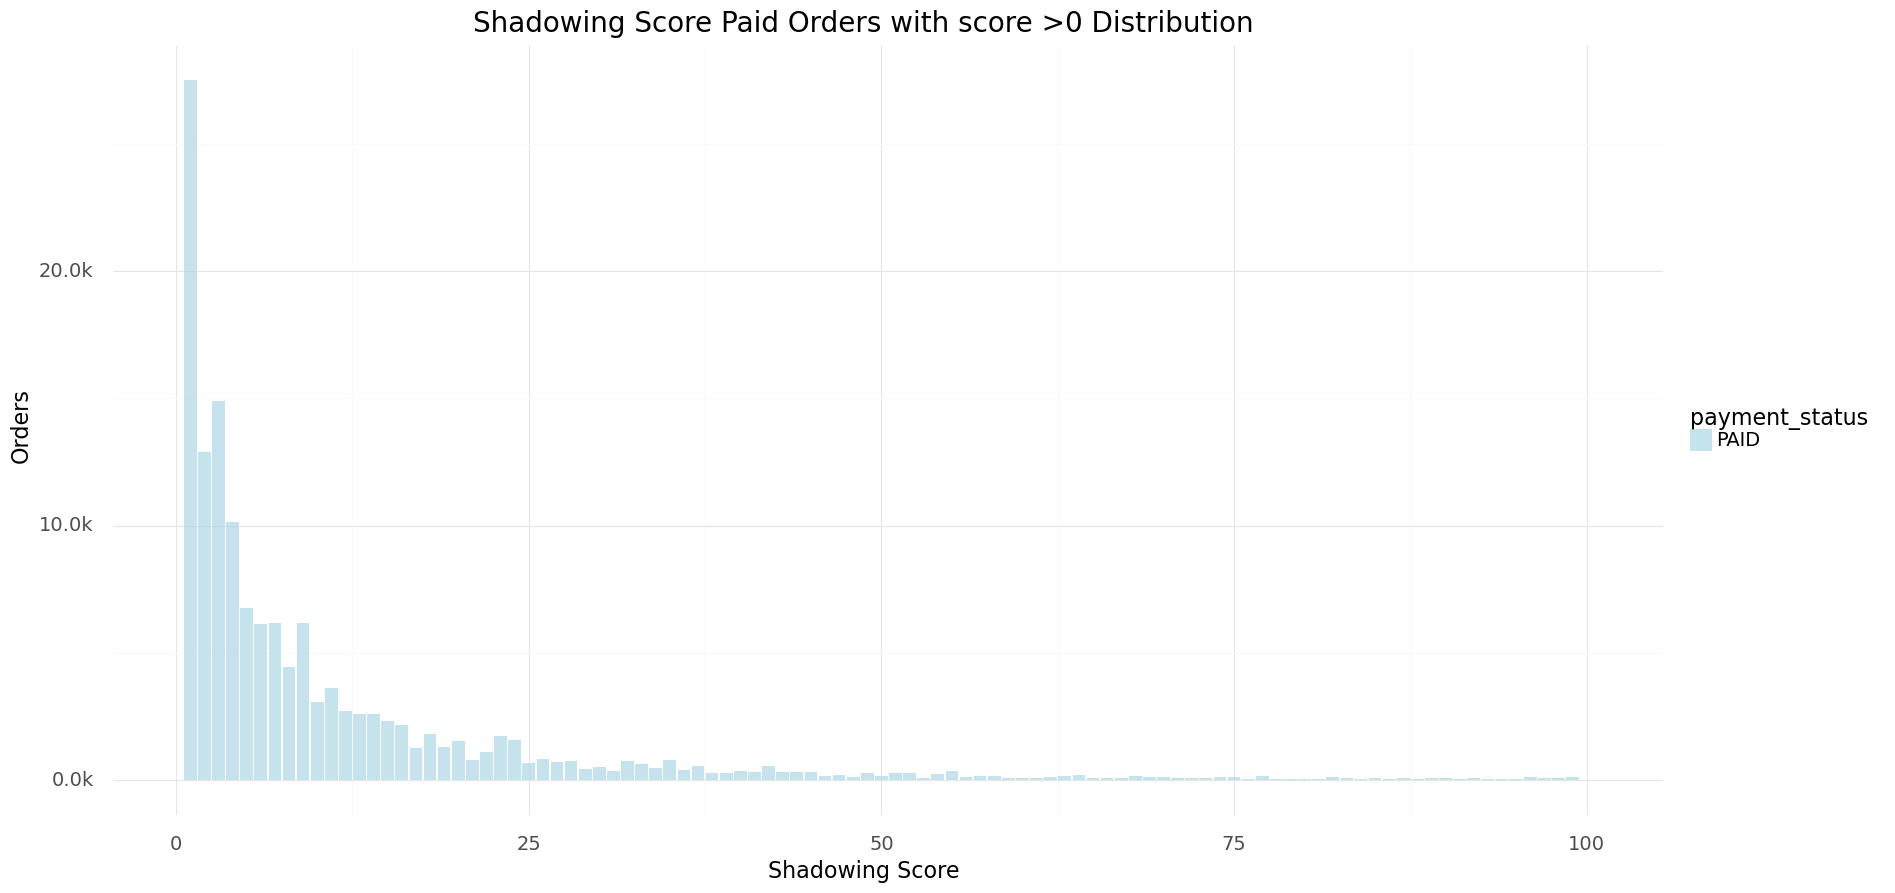

<ggplot: (765708105)>

In [82]:
(
    pn.ggplot(shadowing_score.query('payment_status=="PAID" & shadowing_score>0').reset_index(drop=True)) +
    pn.geom_bar(pn.aes(x='shadowing_score', y='counts', fill="payment_status"), stat="identity", alpha=0.7) +
    pn.scale_fill_manual(values={"PAID": "lightblue"}) + 
    pn.scale_y_continuous(name="Orders", labels=lambda l: ['{:.1f}k'.format(v / 1000) for v in l]
                         ) +
    pn.scale_x_continuous(name="Shadowing Score"#,
                         # breaks=range(int(final_df['MAX_ordersCount'].min()), int(final_df['MAX_ordersCount'].max()) + 1, 1),  # Adjust the range and step as needed
                          #labels=lambda l: ['{:.0f}'.format(v) for v in l]  # Optional formatting for x-axis labels
    ) +
    pn.theme_minimal() +
    pn.labs(title="Shadowing Score Paid Orders with score >0 Distribution")+
    pn.theme(figure_size=(20, 10),  # Adjust figure size as needed
         # Adjusting title and labels size
          title=pn.element_text(size=20),  # Adjust title size
          axis_title=pn.element_text(size=16),  # Adjust axis titles size
          axis_text=pn.element_text(size=14),  # Adjust axis labels size
         # Adjusting legend title and text size
          legend_title=pn.element_text(size=16),  # Adjust legend title size
          legend_text=pn.element_text(size=14))  # Adjust legend text size
)

In [83]:
# Production Score

df_production_score=pd.DataFrame(df['production_score'].value_counts()/len(df))
df_production_score = df_production_score.reset_index()
df_production_score.columns=['production_score','percentage']
#df_production_score

In [84]:
# Shadowing Score

df_shadowing_score=pd.DataFrame(df['shadowing_score'].value_counts()/len(df))
df_shadowing_score = df_shadowing_score.reset_index()
df_shadowing_score.columns=['shadowing_score','percentage']
#df_shadowing_score

In [85]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

display_side_by_side(df_production_score,df_shadowing_score, titles=['Production Score','Shadowing Score'])

,production_score,percentage
0,0,9.309759e-01
1,1,1.843701e-02
2,2,1.065106e-02
3,3,6.112205e-03
4,4,5.952204e-03
5,5,3.749833e-03
6,6,3.283947e-03
7,7,2.406293e-03
8,8,1.965506e-03
9,10,1.828250e-03


# Crosstab

In [86]:
# Ground truth, the user has a successful verification and at least 1 order is a trusted user, in case not a bot.
pd.crosstab(
    df['customer_type'],
    df['payment_status'],
    dropna=False,
    normalize='all'
)

payment_status,NOT_PAID,PAID,PENDING
customer_type,,,
EC,0.006645,0.917574,7.843199e-07
NC,0.001966,0.073815,0.000000e+00


# Adding unpaid flag

In [87]:
df['unpaid']=df['payment_status'].apply(lambda x: 1 if x == 'NOT_PAID' else 0)

# Production score evaluation

/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_89033/1154602147.py:4: RuntimeWarning: invalid value encountered in divide


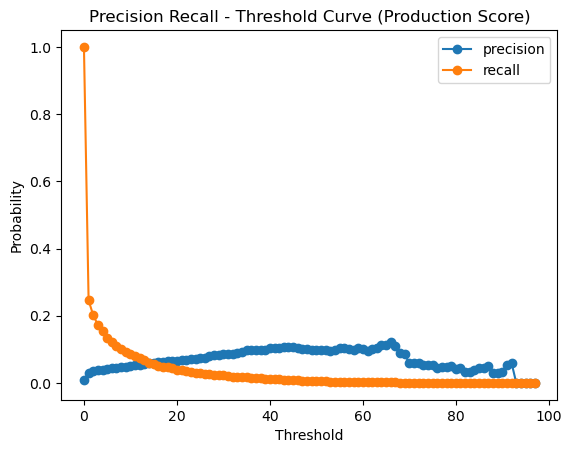

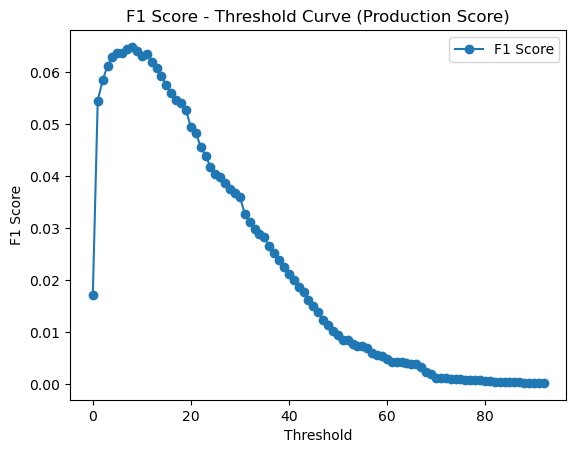

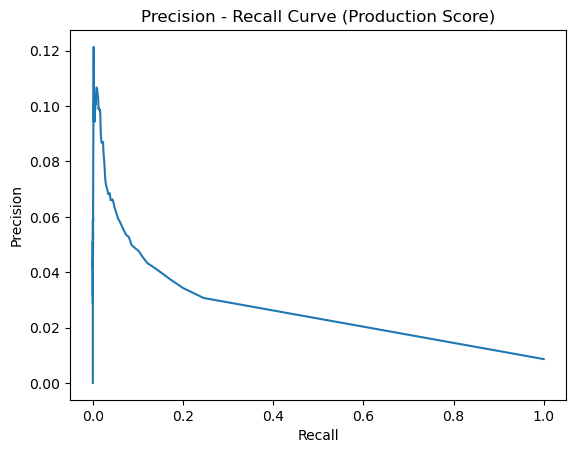

In [88]:

# Here we are looking for the precision and recall of the oposite case. 
# Case of how good is production model for detecting unpaid cash being 1 the positive label.
prec_1, recall_1, thresholds_1 = precision_recall_curve(df['unpaid'].values, df['production_score'].values, pos_label=1)
f1_scores_1 = 2 * (prec_1* recall_1) / (prec_1 + recall_1)

plt.plot(thresholds_1[:], prec_1[:-1]
         , label='precision', marker='o')
plt.plot(thresholds_1[:], recall_1[:-1], label='recall', marker='o')
plt.legend()
plt.title("Precision Recall - Threshold Curve (Production Score)")
plt.ylabel("Probability")
plt.xlabel("Threshold")

plt.figure()

plt.plot(thresholds_1[:], f1_scores_1[:-1], label='F1 Score', marker='o')
plt.legend()
plt.title("F1 Score - Threshold Curve (Production Score)")
plt.ylabel("F1 Score")
plt.xlabel("Threshold")

plt.figure()

plt.plot(recall_1[:-1], prec_1[:-1])
plt.title("Precision - Recall Curve (Production Score)")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()



#  Shadowing score evaluation

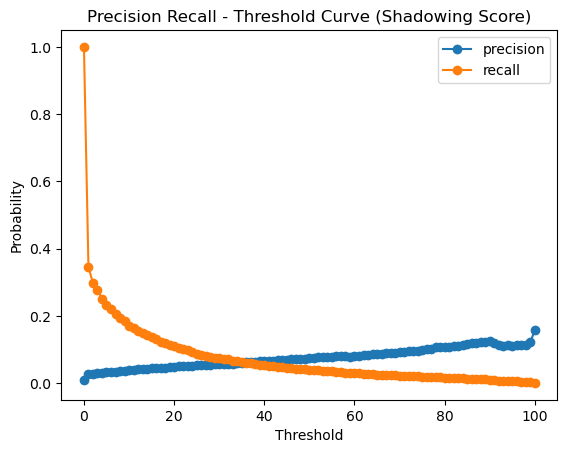

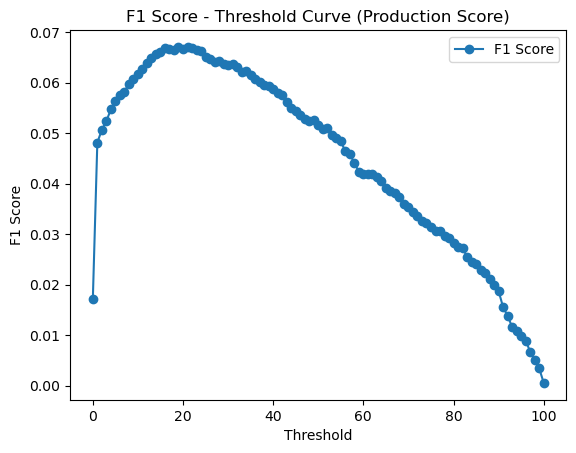

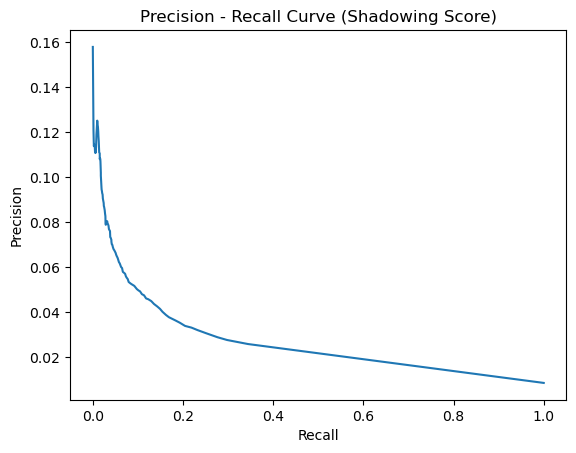

In [89]:
# Here we are looking for the precision and recall of the oposite case. 
# Case of how good is shadowing model for detecting unpaid cash being 1 the positive label.
prec_2, recall_2, thresholds_2 = precision_recall_curve(df['unpaid'].values, df['shadowing_score'].values, pos_label=1)
f1_scores_2 = 2 * (prec_2* recall_2) / (prec_2 + recall_2)

plt.plot(thresholds_2[:], prec_2[:-1], label='precision', marker='o')
plt.plot(thresholds_2[:], recall_2[:-1], label='recall', marker='o')
plt.legend()
plt.title("Precision Recall - Threshold Curve (Shadowing Score)")
plt.ylabel("Probability")
plt.xlabel("Threshold")

plt.figure()

plt.plot(thresholds_2[:], f1_scores_2[:-1], label='F1 Score', marker='o')
plt.legend()
plt.title("F1 Score - Threshold Curve (Production Score)")
plt.ylabel("F1 Score")
plt.xlabel("Threshold")


plt.figure()

plt.plot(recall_2[:-1], prec_2[:-1])
plt.title("Precision - Recall Curve (Shadowing Score)")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

# Model comparison

In [90]:
# Convert payment_status to binary where NOT_PAID is 1 and PAID is 0
df['true_label'] = df['unpaid']

/var/folders/4k/58k3mbxd34b4zcc9nfy33qn00000gp/T/ipykernel_89033/47345187.py:5: RuntimeWarning: invalid value encountered in divide


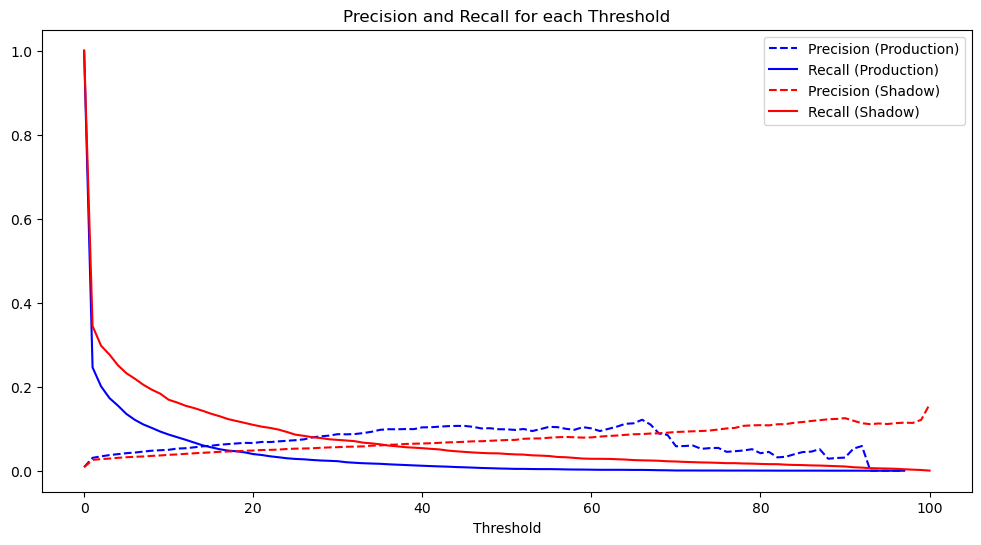

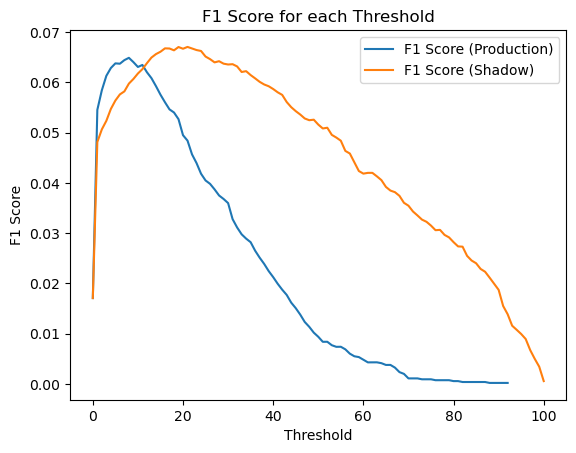

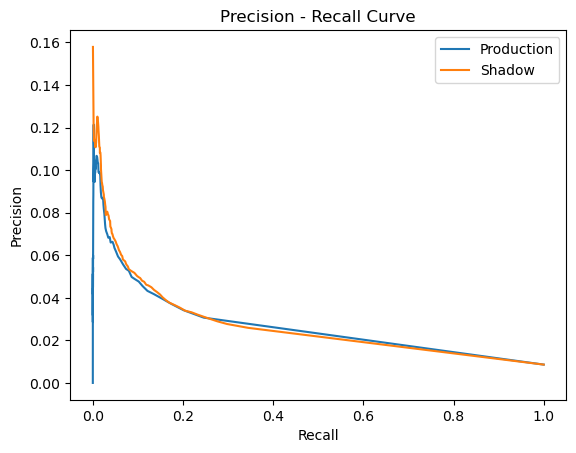

In [91]:
# Calculate precision, recall, and thresholds for each model
precision_production, recall_production, thresholds_production = precision_recall_curve(df['true_label'], df['production_score'])
precision_shadow, recall_shadow, thresholds_shadow = precision_recall_curve(df['true_label'], df['shadowing_score'])

f1_production = 2 * (precision_production* recall_production) / (precision_production + recall_production)
f1_shadow = 2 * (precision_shadow* recall_shadow) / (precision_shadow + recall_shadow)

# Plot precision and recall against the threshold for each model
plt.figure(figsize=(12, 6))

plt.plot(thresholds_production, precision_production[:-1], 'b--', label='Precision (Production)')
plt.plot(thresholds_production, recall_production[:-1], 'b-', label='Recall (Production)')
plt.plot(thresholds_shadow, precision_shadow[:-1], 'r--', label='Precision (Shadow)')
plt.plot(thresholds_shadow, recall_shadow[:-1], 'r-', label='Recall (Shadow)')
plt.xlabel('Threshold')
plt.title('Precision and Recall for each Threshold')
plt.legend()

plt.figure()

plt.plot(thresholds_production, f1_production[:-1], label='F1 Score (Production)')
plt.plot(thresholds_shadow, f1_shadow[:-1], label='F1 Score (Shadow)')
plt.legend()
plt.title("F1 Score for each Threshold")
plt.ylabel("F1 Score")
plt.xlabel("Threshold")

plt.figure()

plt.plot(recall_production[:-1], precision_production[:-1], label="Production")
plt.plot(recall_shadow[:-1], precision_shadow[:-1], label="Shadow")
plt.title("Precision - Recall Curve")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()  # This line will display the labels
plt.show()


plt.show()

# ROC Curves with AUC

Thresholds: [inf 97. 96. 95. 94. 93. 92. 91. 90. 89. 88. 87. 86. 85. 84. 83. 82. 81.
 80. 79. 78. 76. 75. 74. 73. 72. 71. 70. 69. 68. 67. 66. 65. 64. 63. 62.
 61. 60. 59. 58. 57. 56. 55. 54. 53. 52. 51. 50. 49. 48. 47. 46. 45. 44.
 43. 42. 41. 40. 39. 38. 37. 36. 35. 34. 33. 32. 31. 30. 29. 28. 27. 26.
 25. 24. 23. 22. 21. 20. 19. 18. 17. 16. 15. 14. 13. 12. 11. 10.  9.  8.
  7.  6.  5.  4.  3.  2.  1.  0.]
AUC: 0.5909296654867262


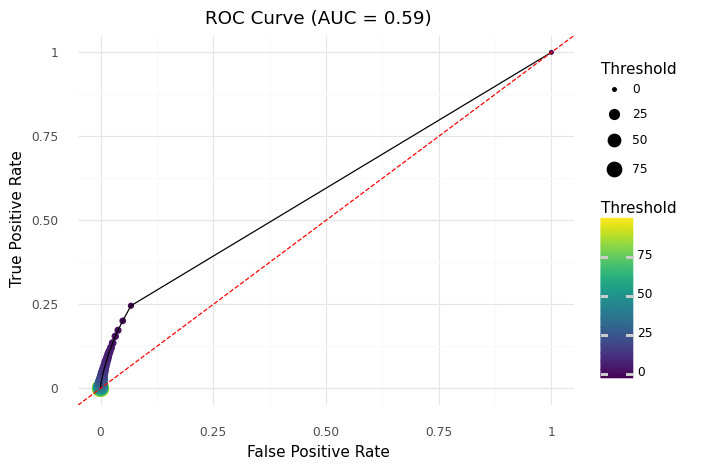

<ggplot: (763751505)>

In [92]:
# Production model
plot_roc_curve(df, preds_col='production_score', label_col='unpaid')

Thresholds: [ inf 100.  99.  98.  97.  96.  95.  94.  93.  92.  91.  90.  89.  88.
  87.  86.  85.  84.  83.  82.  81.  80.  79.  78.  77.  76.  75.  74.
  73.  72.  71.  70.  69.  68.  67.  66.  65.  64.  63.  62.  61.  60.
  59.  58.  57.  56.  55.  54.  53.  52.  51.  50.  49.  48.  47.  46.
  45.  44.  43.  42.  41.  40.  39.  38.  37.  36.  35.  34.  33.  32.
  31.  30.  29.  28.  27.  26.  25.  24.  23.  22.  21.  20.  19.  18.
  17.  16.  15.  14.  13.  12.  11.  10.   9.   8.   7.   6.   5.   4.
   3.   2.   1.   0.]
AUC: 0.6200611843018476


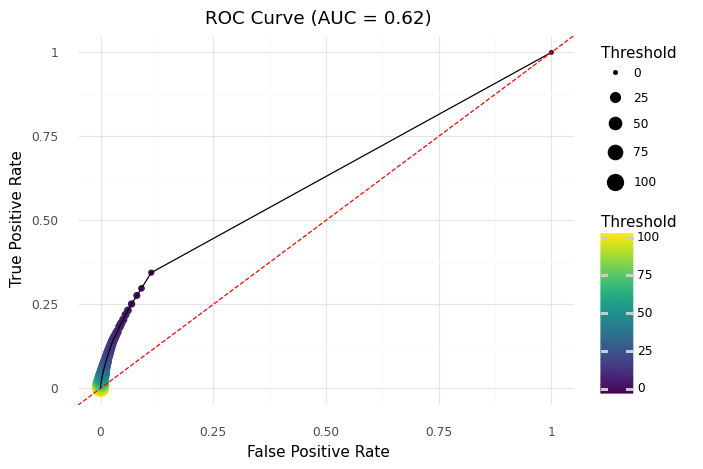

<ggplot: (763471469)>

In [93]:
# Shadowing Model
plot_roc_curve(df, preds_col='shadowing_score', label_col='unpaid')